# A Machine Learning Approach for Detection of Fraudulent Transactions in Financial Services

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [4]:
# Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn imblearn shap

##Importing Necessary Libraries

In [5]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, roc_curve, auc)
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import shap

##Loading Datasets

In [ ]:
# Load the data
chunk_size = 50000  # Adjust based on memory available
train_transaction_iter = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/train_transaction.csv", chunksize=chunk_size)
train_identity_iter = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/train_identity.csv", chunksize=chunk_size)

train_transaction = pd.concat([chunk for chunk in train_transaction_iter])
train_identity = pd.concat([chunk for chunk in train_identity_iter])

# Memory optimization function
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# Apply memory optimization
train_transaction = reduce_memory_usage(train_transaction)
train_identity = reduce_memory_usage(train_identity)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is 10.00 MB
Decreased by 77.8%


##Undersampling the Dataset

In [ ]:
#  Balance the dataset by under-sampling the non-fraudulent transactions

# Separate fraud and non-fraud transactions
fraud_df = train_transaction[train_transaction['isFraud'] == 1]
non_fraud_df = train_transaction[train_transaction['isFraud'] == 0]

# Get the number of fraud samples
num_fraud = len(fraud_df)

# Under-sample non-fraud transactions to match the number of fraud transactions
non_fraud_under = non_fraud_df.sample(n=num_fraud, random_state=42)

# Combine fraud and under-sampled non-fraud data into a new balanced dataset
balanced_transaction = pd.concat([fraud_df, non_fraud_under])

# Shuffle the dataset to avoid ordering bias
balanced_transaction = balanced_transaction.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the undersampled dataset to the specified directory
balanced_transaction.to_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/balanced_transaction.csv", index=False)
print("Balanced dataset saved as 'balanced_transaction.csv'.")

# Check the class distribution after balancing
print(f"\nBalanced Dataset Class Distribution:\n{balanced_transaction['isFraud'].value_counts()}")

Balanced dataset saved as 'balanced_transaction.csv'.

Balanced Dataset Class Distribution:
isFraud
0    20663
1    20663
Name: count, dtype: int64


In [ ]:
# Load the saved balanced dataset from Google Drive
balanced_transaction = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/balanced_transaction.csv")

print("First 5 rows of the loaded balanced dataset:")
balanced_transaction.head()

First 5 rows of the loaded balanced dataset:


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        3560282        0       15219936           30.62         C   4504   
1        3501066        1       13458191          994.00         W  16132   
2        3139053        1        3146178          115.00         W   5964   
3        3052644        0        1471552          214.00         W  10486   
4        3369536        1        9580231           13.66         C   8121   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0  500.0  185.0  mastercard  219.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  111.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  268.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  514.0  150.0  mastercard  219.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  555.0  185.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  NaN   NaN   NaN   NaN  

[5 rows x 394 columns]

In [ ]:
print("\nLoaded Balanced Dataset Class Distribution:")
balanced_transaction['isFraud'].value_counts()


Loaded Balanced Dataset Class Distribution:


isFraud
0    20663
1    20663
Name: count, dtype: int64


Balanced Dataset Class Distribution:
isFraud
0    20663
1    20663
Name: count, dtype: int64


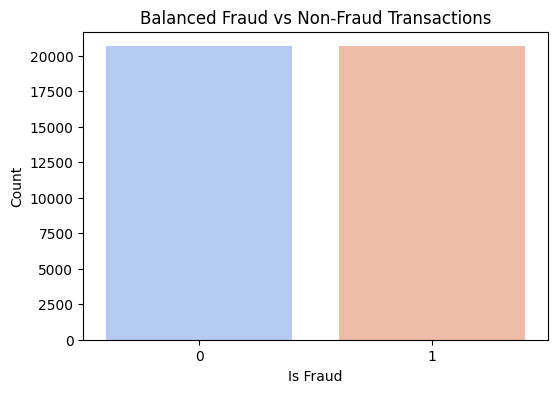

In [ ]:
# Check the class distribution after balancing
print(f"\nBalanced Dataset Class Distribution:\n{balanced_transaction['isFraud'].value_counts()}")

# Data Preprocessing
small_sampled_train_transaction = balanced_transaction.copy()

# Visualize the new balanced class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=small_sampled_train_transaction, palette='coolwarm')
plt.title('Balanced Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

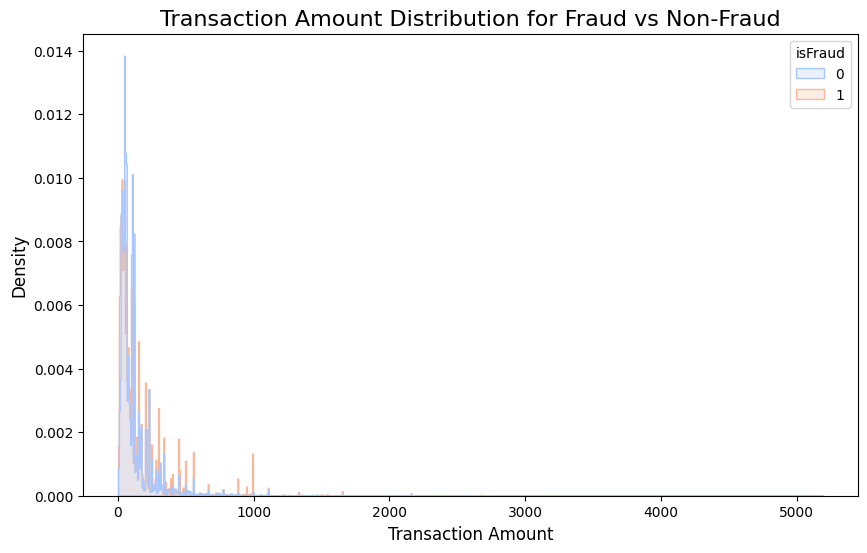

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=balanced_transaction, x='TransactionAmt', hue='isFraud', element="step", stat="density", common_norm=False, palette='coolwarm')
plt.title('Transaction Amount Distribution for Fraud vs Non-Fraud', fontsize=16)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

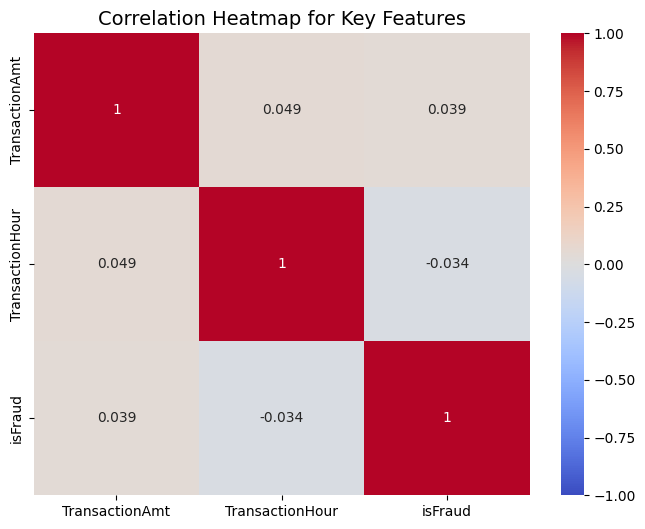

In [ ]:
# Create new time-based features if not done already
balanced_transaction['TransactionHour'] = (balanced_transaction['TransactionDT'] / 3600) % 24

corr_matrix = balanced_transaction[['TransactionAmt', 'TransactionHour', 'isFraud']].corr()

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Key Features', fontsize=14)
plt.show()

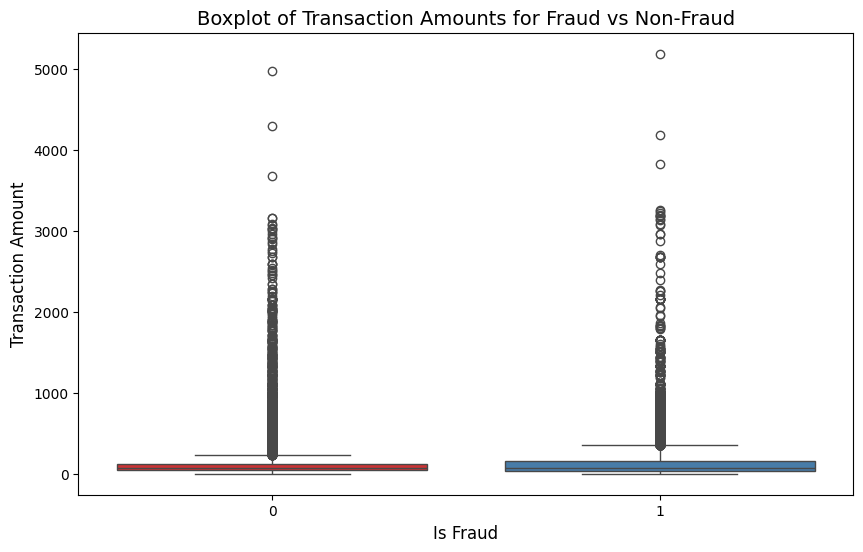

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_transaction, palette='Set1')
plt.title('Boxplot of Transaction Amounts for Fraud vs Non-Fraud', fontsize=14)
plt.xlabel('Is Fraud', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.show()

In [ ]:
#Balance the dataset by under-sampling non-fraud transactions

# Separate fraud and non-fraud transactions
fraud_df = train_transaction[train_transaction['isFraud'] == 1]
non_fraud_df = train_transaction[train_transaction['isFraud'] == 0]

# Get the number of fraud samples
num_fraud = len(fraud_df)

# Under-sample non-fraud transactions to match the number of fraud transactions
non_fraud_under = non_fraud_df.sample(n=num_fraud, random_state=42)

# Combine fraud and under-sampled non-fraud data into a new balanced dataset
balanced_transaction = pd.concat([fraud_df, non_fraud_under])

# Shuffle the dataset to avoid ordering bias
balanced_transaction = balanced_transaction.sample(frac=1, random_state=42).reset_index(drop=True)

#  Preview the balanced dataset
print(f"Shape of balanced train_transaction: {balanced_transaction.shape}")
print(f"Shape of train_identity: {train_identity.shape}")

Shape of balanced train_transaction: (41326, 394)
Shape of train_identity: (144233, 41)


In [ ]:
# Display the first few rows of both datasets to understand the structure
print("\nFirst 5 rows of train_identity:")
train_identity.head()


First 5 rows of train_identity:


TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                     DeviceInfo  
0     F     T      T      mobile  SAMSUNG SM-G892A Build/NRD90M  
1     F     F      T      mobile                     iOS Device  
2     F     T      T     desktop                        Windows  
3     F     T      T     desktop                            NaN  
4     F     T      T     desktop                          MacOS  

[5 rows x 41 columns]

In [ ]:
print("\nFirst 5 rows of balanced train_transaction:")
balanced_transaction.head()


First 5 rows of balanced train_transaction:


TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        3560282        0       15219936        30.62500         C   4504   
1        3501066        1       13458191       994.00000         W  16132   
2        3139053        1        3146178       115.00000         W   5964   
3        3052644        0        1471552       214.00000         W  10486   
4        3369536        1        9580231        13.65625         C   8121   

   card2  card3       card4  card5  ... V330  V331  V332  V333  V334 V335  \
0  500.0  185.0  mastercard  219.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
1  111.0  150.0        visa  226.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
2  268.0  150.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
3  514.0  150.0  mastercard  219.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   
4  555.0  185.0        visa  166.0  ...  NaN   NaN   NaN   NaN   NaN  NaN   

  V336  V337  V338  V339  
0  NaN   NaN   NaN   NaN  
1  NaN   NaN   NaN   NaN  
2  NaN   NaN   NaN   NaN  
3  NaN   NaN   NaN   NaN  
4  NaN   NaN   NaN   NaN  

[5 rows x 394 columns]

In [ ]:
# Generate summary statistics for numerical columns in the balanced transaction dataset
print("\nSummary statistics of balanced train_transaction:")
balanced_transaction.describe()


Summary statistics of balanced train_transaction:


TransactionID       isFraud  TransactionDT  TransactionAmt  \
count   4.132600e+04  41326.000000   4.132600e+04    4.132600e+04   
mean    3.288300e+06      0.500000   7.522608e+06             inf   
std     1.664160e+05      0.500006   4.520040e+06             inf   
min     2.987002e+06      0.000000   8.646900e+04    2.919922e-01   
25%     3.151302e+06      0.000000   3.501798e+06    3.900000e+01   
50%     3.287640e+06      0.500000   7.423690e+06    7.193750e+01   
75%     3.428432e+06      1.000000   1.121350e+07    1.500000e+02   
max     3.577531e+06      1.000000   1.581094e+07    5.192000e+03   

              card1    card2         card3        card5       addr1  \
count  41326.000000  40566.0  4.122500e+04  40966.00000  31419.0000   
mean    9738.212167      inf           inf          inf         inf   
std     4834.034113      inf  1.538281e+01     43.71875    102.8125   
min     1012.000000    100.0  1.000000e+02    100.00000    110.0000   
25%     5819.000000    206.0  1.500000e+02    166.00000    204.0000   
50%     9633.000000    370.0  1.500000e+02    224.00000    299.0000   
75%    13832.000000    513.0  1.500000e+02    226.00000    330.0000   
max    18395.000000    600.0  2.310000e+02    237.00000    540.0000   

              addr2  ...         V330          V331           V332  \
count  3.141900e+04  ...  6540.000000   6540.000000    6540.000000   
mean            inf  ...     0.463623    321.706390     614.792480   
std    3.759766e+00  ...     2.949219   3824.103027    7047.087891   
min    1.000000e+01  ...     0.000000      0.000000       0.000000   
25%    8.700000e+01  ...     0.000000      0.000000       0.000000   
50%    8.700000e+01  ...     0.000000      0.000000       0.000000   
75%    8.700000e+01  ...     0.000000     20.000000     100.000000   
max    1.020000e+02  ...    49.000000  92463.000000  144379.000000   

                V333     V334     V335     V336         V337         V338  \
count    6540.000000   6540.0   6540.0   6540.0  6540.000000  6540.000000   
mean      461.422729      inf      inf      inf    42.363426    86.673668   
std      5093.205078      inf      inf      inf   246.801590   601.651917   
min         0.000000      0.0      0.0      0.0     0.000000     0.000000   
25%         0.000000      0.0      0.0      0.0     0.000000     0.000000   
50%         0.000000      0.0      0.0      0.0     0.000000     0.000000   
75%        60.000000      0.0      0.0      0.0     0.000000     0.000000   
max    102879.000000  30256.0  41696.0  30256.0  9000.000000  9000.000000   

              V339  
count  6540.000000  
mean     62.720001  
std     380.601227  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max    9000.000000  

[8 rows x 380 columns]

In [ ]:
# Check for missing values in both datasets
print("\nMissing values in train_identity:")
train_identity.isnull().sum()


Missing values in train_identity:


TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [ ]:
print("\nMissing values in balanced train_transaction:")
balanced_transaction.isnull().sum()


Missing values in balanced train_transaction:


TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
V335              34786
V336              34786
V337              34786
V338              34786
V339              34786
Length: 394, dtype: int64

In [ ]:
#  Load the balanced dataset
balanced_transaction = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/balanced_transaction.csv")
train_identity = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shubham-Dis/train_identity.csv")

# Merge the balanced_transaction with train_identity based on TransactionID
balanced_data = pd.merge(balanced_transaction, train_identity, on='TransactionID', how='left')

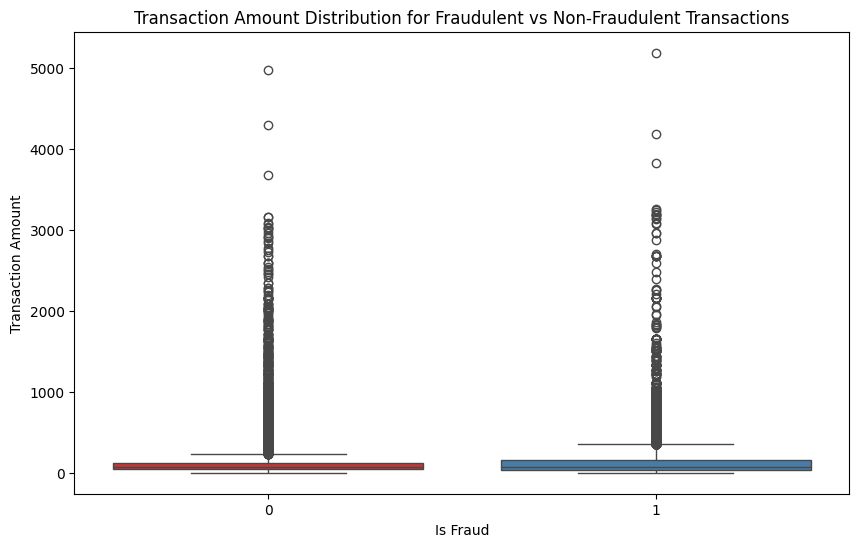

In [ ]:
#Explore relationships between key features
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_data, palette='Set1')
plt.title('Transaction Amount Distribution for Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

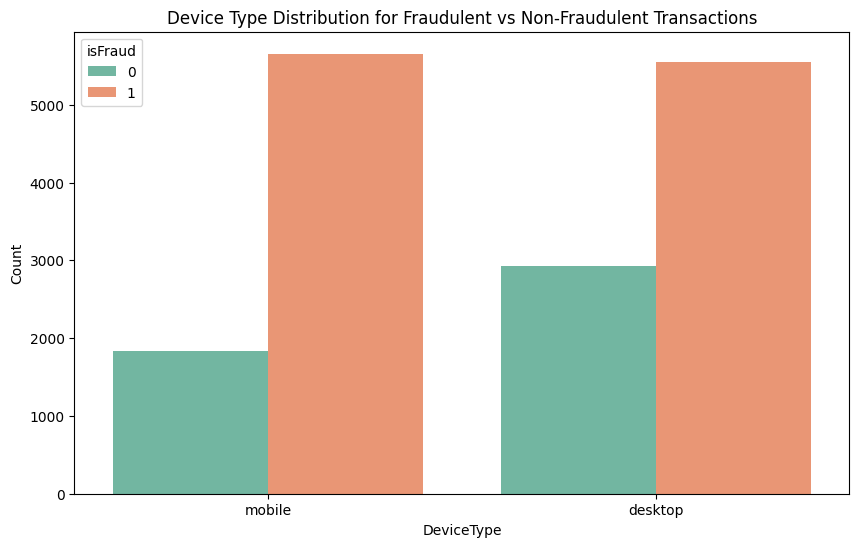

In [ ]:
#  Explore identity-related features if applicable (e.g., 'DeviceType' in the identity data)
plt.figure(figsize=(10,6))
sns.countplot(x='DeviceType', hue='isFraud', data=balanced_data, palette='Set2')
plt.title('Device Type Distribution for Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('DeviceType')
plt.ylabel('Count')
plt.show()

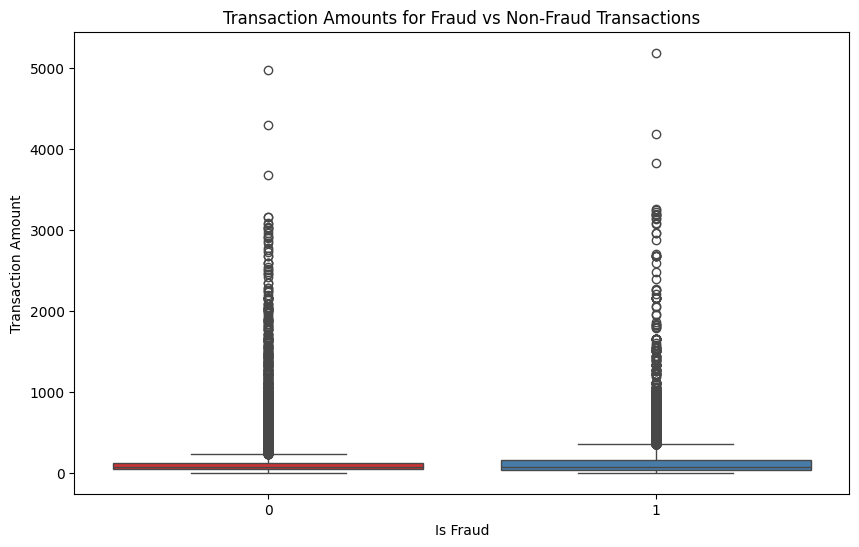

In [ ]:
# Explore relationships between key features (Transaction Amount vs Fraud)
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_data, palette='Set1')
plt.title('Transaction Amounts for Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

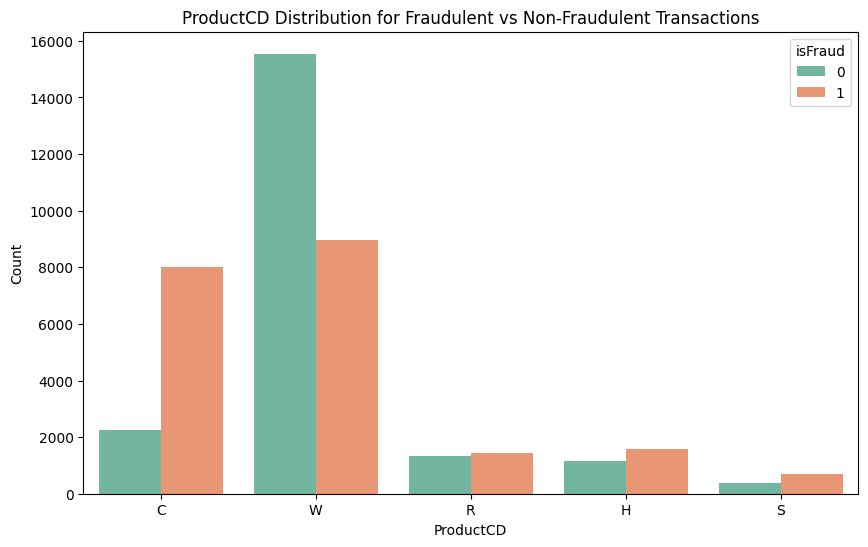

In [ ]:
#  Explore categorical features (ProductCD vs Fraud)
plt.figure(figsize=(10,6))
sns.countplot(x='ProductCD', hue='isFraud', data=balanced_data, palette='Set2')
plt.title('ProductCD Distribution for Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('ProductCD')
plt.ylabel('Count')
plt.show()

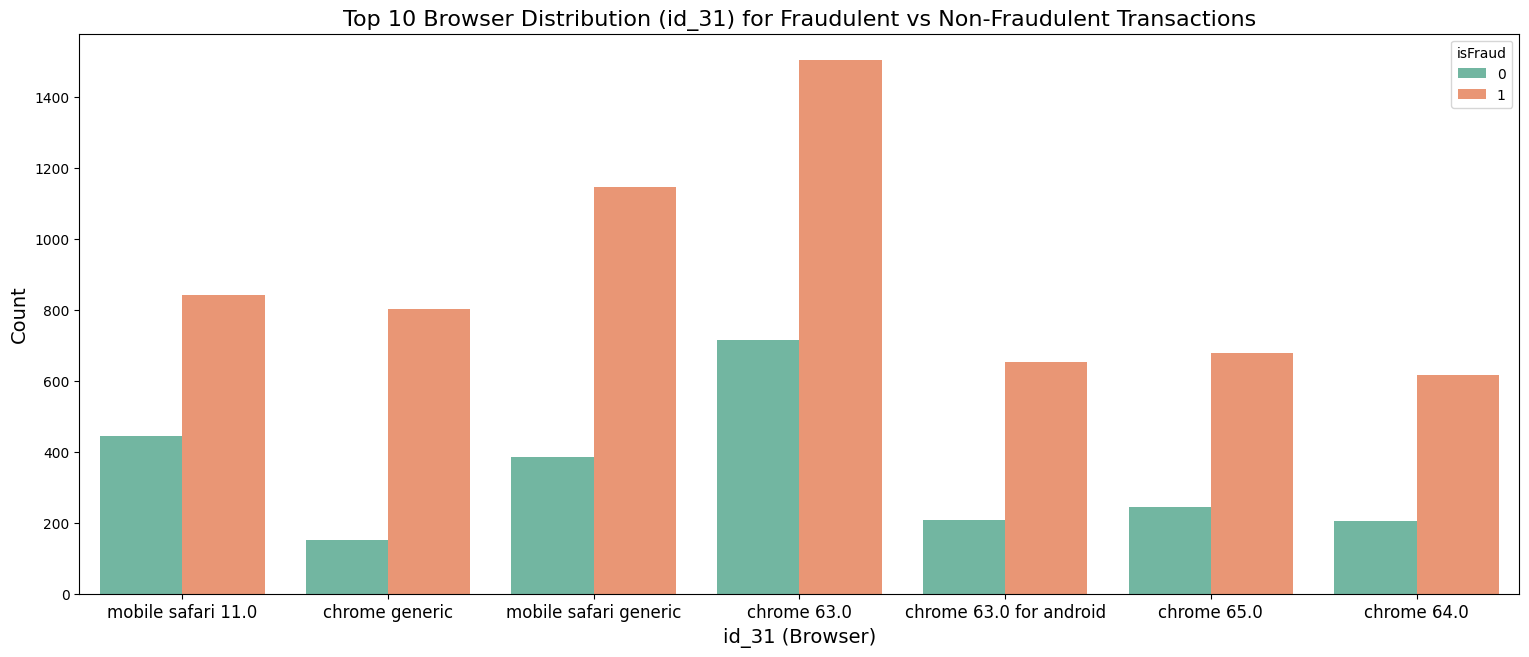

In [ ]:
# Select the top 10 most common browsers
top_browsers = balanced_data['id_31'].value_counts().nlargest(7).index

# Filter the dataset to include only the top 10 browsers
filtered_data = balanced_data[balanced_data['id_31'].isin(top_browsers)]

# Plot the countplot for the filtered data with increased width and spacing between bars
plt.figure(figsize=(16,8))  # Increased width to 18
sns.countplot(x='id_31', hue='isFraud', data=filtered_data, palette='Set2')

# Adjusting the title and labels
plt.title('Top 10 Browser Distribution (id_31) for Fraudulent vs Non-Fraudulent Transactions', fontsize=16)
plt.xlabel('id_31 (Browser)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Set x-ticks with no rotation and add padding for better visibility
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.tight_layout()

# Add some padding to the layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.2)

plt.show()

## Outliers Removal

In [ ]:
#  Define a function to remove outliers based on IQR for a given feature
def remove_outliers_iqr(df, feature, lower_quantile=0.25, upper_quantile=0.75):
    # Calculate the IQR (Interquartile Range)
    Q1 = df[feature].quantile(lower_quantile)
    Q3 = df[feature].quantile(upper_quantile)
    IQR = Q3 - Q1

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the rows that have outliers
    filtered_df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

    print(f"Outliers removed for {feature}: {df.shape[0] - filtered_df.shape[0]}")
    return filtered_df

# Apply the IQR-based outlier removal to specific continuous features like 'TransactionAmt'
# Using the merged dataset balanced_data
print("Before removing outliers: ", balanced_data.shape)

# Remove outliers for 'TransactionAmt'
balanced_data = remove_outliers_iqr(balanced_data, 'TransactionAmt')

balanced_data = remove_outliers_iqr(balanced_data, 'D15')

print("After removing outliers: ", balanced_data.shape)

Before removing outliers:  (41326, 434)
Outliers removed for TransactionAmt: 3837
Outliers removed for D15: 8911
After removing outliers:  (28578, 434)


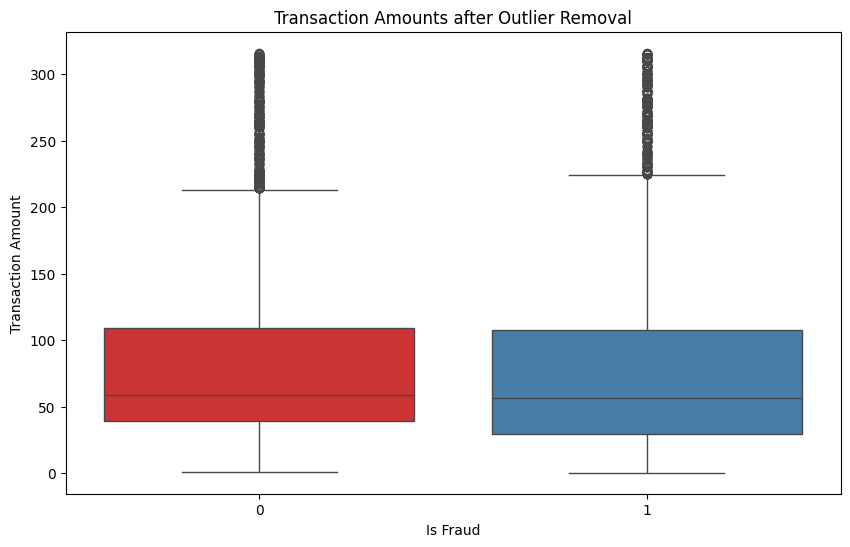

In [ ]:
# Verify by plotting boxplots to see if the outliers were successfully removed
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_data, palette='Set1')
plt.title('Transaction Amounts after Outlier Removal')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

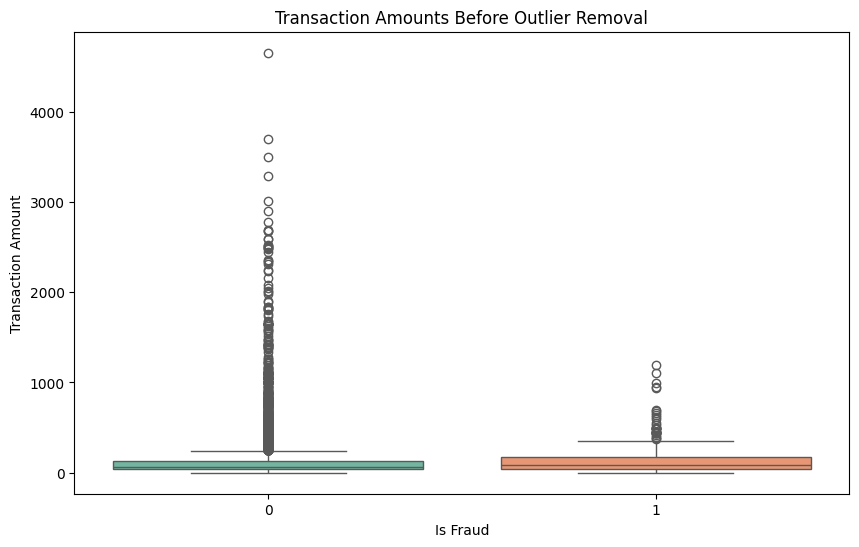

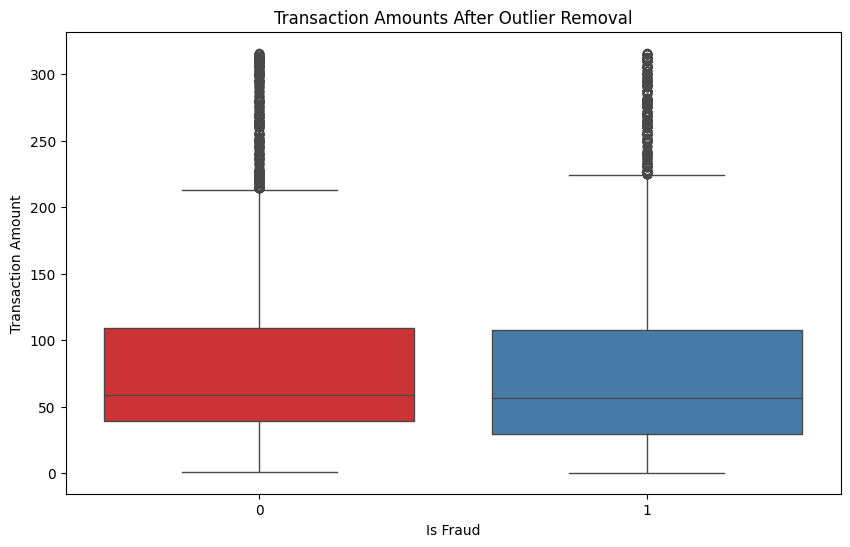

In [ ]:
# Before outlier removal
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=train_transaction.sample(n=10000, random_state=42), palette='Set2')
plt.title('Transaction Amounts Before Outlier Removal')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

# After outlier removal
plt.figure(figsize=(10,6))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_data, palette='Set1')
plt.title('Transaction Amounts After Outlier Removal')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

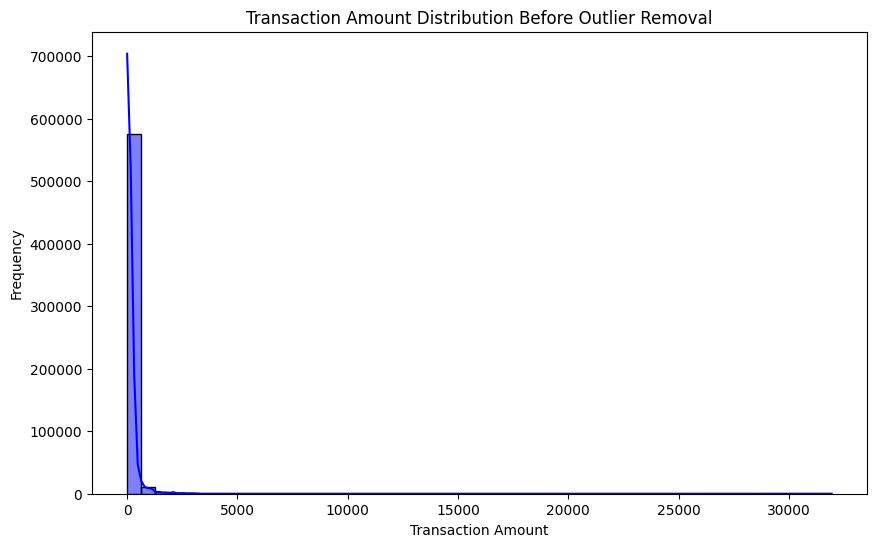

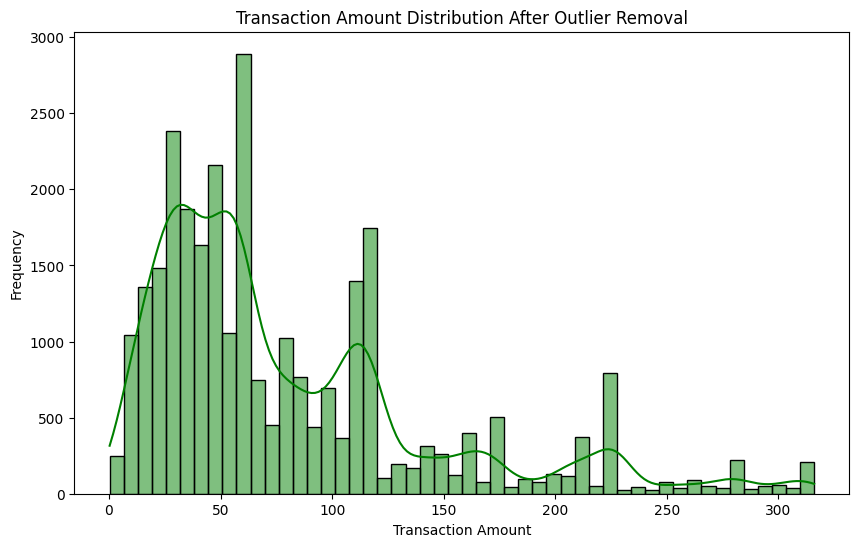

In [ ]:
# Before outlier removal - Distribution plot
plt.figure(figsize=(10,6))
sns.histplot(train_transaction['TransactionAmt'], bins=50, color='blue', kde=True)
plt.title('Transaction Amount Distribution Before Outlier Removal')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

# After outlier removal - Distribution plot
plt.figure(figsize=(10,6))
sns.histplot(balanced_data['TransactionAmt'], bins=50, color='green', kde=True)
plt.title('Transaction Amount Distribution After Outlier Removal')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

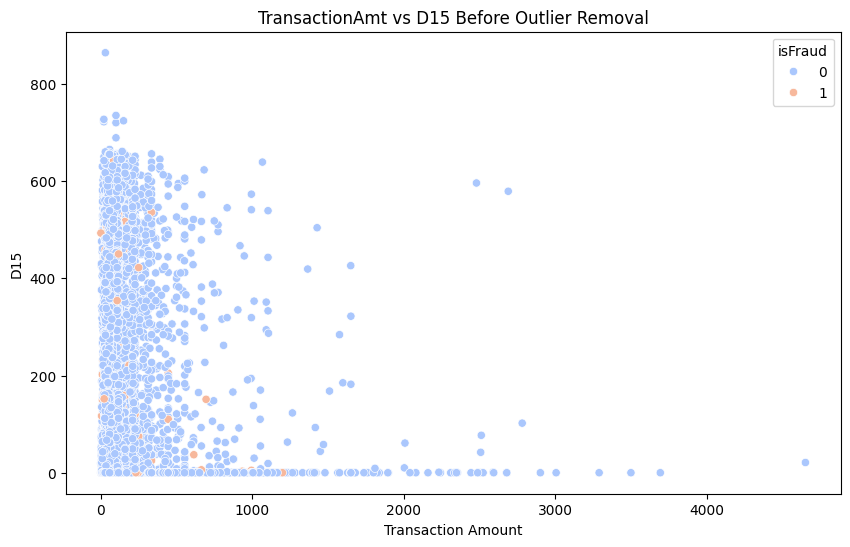

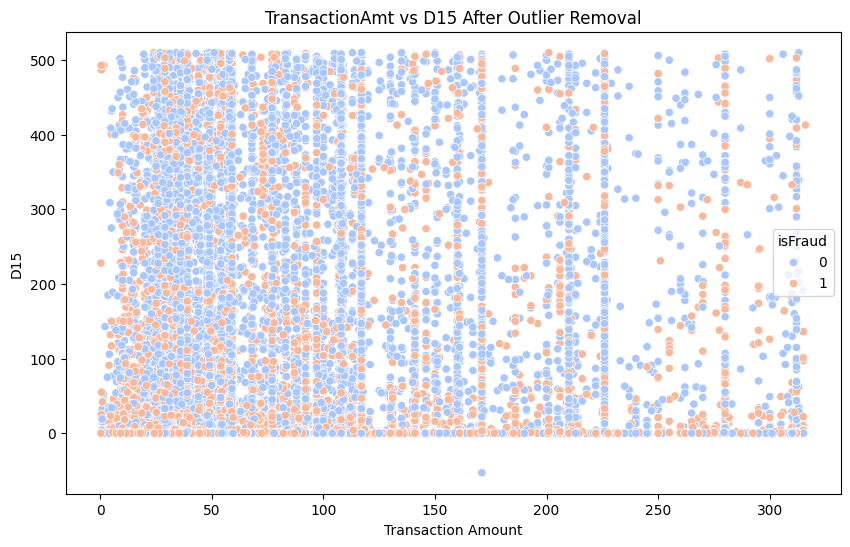

In [ ]:
# Before outlier removal - Scatter plot of TransactionAmt vs. D15
plt.figure(figsize=(10,6))
sns.scatterplot(x='TransactionAmt', y='D15', data=train_transaction.sample(n=10000, random_state=42), hue='isFraud', palette='coolwarm')
plt.title('TransactionAmt vs D15 Before Outlier Removal')
plt.xlabel('Transaction Amount')
plt.ylabel('D15')
plt.show()

# After outlier removal - Scatter plot of TransactionAmt vs. D15
plt.figure(figsize=(10,6))
sns.scatterplot(x='TransactionAmt', y='D15', data=balanced_data, hue='isFraud', palette='coolwarm')
plt.title('TransactionAmt vs D15 After Outlier Removal')
plt.xlabel('Transaction Amount')
plt.ylabel('D15')
plt.show()

## Handling Missing Values

In [ ]:
# Drop columns with more than 60% missing values
def drop_columns_with_missing_data(df, threshold=0.6):
    missing_ratio = df.isnull().mean()
    cols_to_drop = missing_ratio[missing_ratio > threshold].index
    print(f"Columns to drop due to missing values above {threshold*100}% threshold: {len(cols_to_drop)}")
    return df.drop(columns=cols_to_drop)

# Apply to balanced_data
balanced_data = drop_columns_with_missing_data(balanced_data)

# Impute missing values for numerical and categorical features
def impute_missing_values(df):
    # Select numerical and categorical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    # Impute numerical columns with the mean
    for col in num_cols:
        mean_value = df[col].mean()
        df[col].fillna(mean_value, inplace=True)
        print(f"Imputed missing values in {col} with mean: {mean_value:.2f}")

    # Impute categorical columns with the mode (most frequent value)
    for col in cat_cols:
        if df[col].isnull().sum() > 0:  # Check if column has missing values
            mode_value = df[col].mode()[0]
            df[col].fillna(mode_value, inplace=True)
            print(f"Imputed missing values in {col} with mode: {mode_value}")

    return df

# Apply the imputation function to balanced_data
balanced_data = impute_missing_values(balanced_data)

# Verify that no missing values remain
print("Missing values in balanced_data after imputation:")
print(balanced_data.isnull().sum().sort_values(ascending=False).head())

Columns to drop due to missing values above 60.0% threshold: 212
Imputed missing values in TransactionID with mean: 3290556.32
Imputed missing values in isFraud with mean: 0.49
Imputed missing values in TransactionDT with mean: 7575142.71
Imputed missing values in TransactionAmt with mean: 80.27
Imputed missing values in card1 with mean: 9756.38
Imputed missing values in card2 with mean: 355.79
Imputed missing values in card3 with mean: 160.53
Imputed missing values in card5 with mean: 194.55
Imputed missing values in addr1 with mean: 292.25
Imputed missing values in addr2 with mean: 86.44
Imputed missing values in C1 with mean: 28.58
Imputed missing values in C2 with mean: 36.07
Imputed missing values in C3 with mean: 0.00
Imputed missing values in C4 with mean: 10.51
Imputed missing values in C5 with mean: 3.59
Imputed missing values in C6 with mean: 14.01
Imputed missing values in C7 with mean: 10.44
Imputed missing values in C8 with mean: 16.49
Imputed missing values in C9 with mea

In [ ]:
# Identify categorical columns in the balanced_data dataset
def get_categorical_columns(df):
    return df.select_dtypes(include=['object']).columns

categorical_cols = get_categorical_columns(balanced_data)

print(f"Categorical columns in balanced_data: {categorical_cols}")

#  Apply Label Encoding or One-Hot Encoding based on need

def encode_categorical_columns(df, categorical_cols):
    for col in categorical_cols:
        if df[col].nunique() < 10:  # Use One-Hot Encoding for low cardinality columns
            df = pd.get_dummies(df, columns=[col], drop_first=True)
            print(f"Applied One-Hot Encoding to {col}")
        else:
          le = LabelEncoder()
          df[col] = le.fit_transform(df[col].astype(str))
          print(f"Applied Label Encoding to {col}")

    return df

#  Apply encoding to the balanced_data dataset
balanced_data = encode_categorical_columns(balanced_data, categorical_cols)

# Verify that all categorical variables are now encoded
print("Sample of the processed balanced_data after encoding:")
print(balanced_data.head())

Categorical columns in balanced_data: Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6'],
      dtype='object')
Applied One-Hot Encoding to ProductCD
Applied One-Hot Encoding to card4
Applied One-Hot Encoding to card6
Applied Label Encoding to P_emaildomain
Applied One-Hot Encoding to M1
Applied One-Hot Encoding to M2
Applied One-Hot Encoding to M3
Applied One-Hot Encoding to M4
Applied One-Hot Encoding to M5
Applied One-Hot Encoding to M6
Sample of the processed balanced_data after encoding:
   TransactionID  isFraud  TransactionDT  TransactionAmt  card1  card2  card3  \
0        3560282        0       15219936           30.62   4504  500.0  185.0   
2        3139053        1        3146178          115.00   5964  268.0  150.0   
3        3052644        0        1471552          214.00  10486  514.0  150.0   
4        3369536        1        9580231           13.66   8121  555.0  185.0   
5        3475222        1       12709428          

In [ ]:
#  Identify numerical columns for scaling in balanced_data
def get_numerical_columns(df):
    return df.select_dtypes(include=['float64', 'int64']).columns

numerical_cols_balanced = get_numerical_columns(balanced_data)

print(f"Numerical columns in balanced_data: {numerical_cols_balanced}")

# Apply scaling only to numerical columns
scaler = StandardScaler()

def scale_numerical_columns(df, numerical_cols, scaler):
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
        print(f"Applied scaling to {len(numerical_cols)} numerical columns.")
    else:
        print("No numerical columns to scale.")
    return df

# Apply scaling to balanced_data
balanced_data = scale_numerical_columns(balanced_data, numerical_cols_balanced, scaler)

# Verify the scaled features in balanced_data
print("Sample of the processed balanced_data after scaling:")
print(balanced_data[numerical_cols_balanced].head())

Numerical columns in balanced_data: Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=213)
Applied scaling to 213 numerical columns.
Sample of the processed balanced_data after scaling:
   TransactionID   isFraud  TransactionDT  TransactionAmt     card1     card2  \
0       1.646022 -0.984513       1.712413       -0.765049 -1.098880  0.923006   
2      -0.924561  1.015730      -0.992076        0.535188 -0.793425 -0.561849   
3      -1.451878 -0.984513      -1.367188        2.060710  0.152648  1.012610   
4       0.481980  1.015730       0.449134       -1.026391 -0.342147  1.275020   
5       1.126937  1.015730       1.150066       -0.404780 -0.533370 -1.566687   

      card3     card5     addr1    addr2  ...      V312      V313      V314  \
0  1.454928  0.561337  0.000000 

In [ ]:
# Check for missing values in the relevant columns
print(balanced_data[['TransactionDT', 'TransactionAmt', 'isFraud']].isnull().sum())

TransactionDT     0
TransactionAmt    0
isFraud           0
dtype: int64


In [ ]:
print(balanced_data.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'card4_visa', 'card6_credit', 'card6_debit', 'M1_T', 'M2_T', 'M3_T',
       'M4_M1', 'M4_M2', 'M5_T', 'M6_T'],
      dtype='object', length=229)


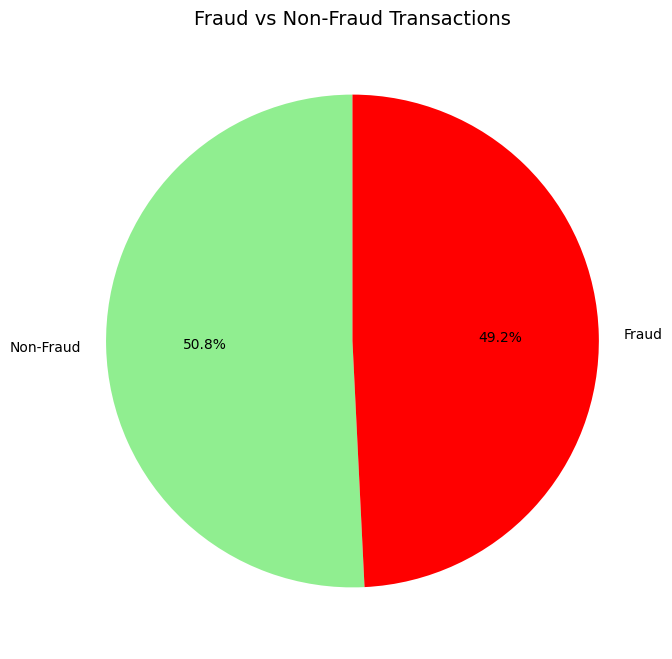

In [ ]:
# Pie chart of Fraud vs Non-Fraud Transactions
fraud_counts = balanced_data['isFraud'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', colors=['lightgreen', 'red'], startangle=90)
plt.title('Fraud vs Non-Fraud Transactions', fontsize=14)
plt.show()

In [ ]:
# Creating TransactionHour feature
balanced_data['TransactionHour'] = (balanced_data['TransactionDT'] / 3600) % 24

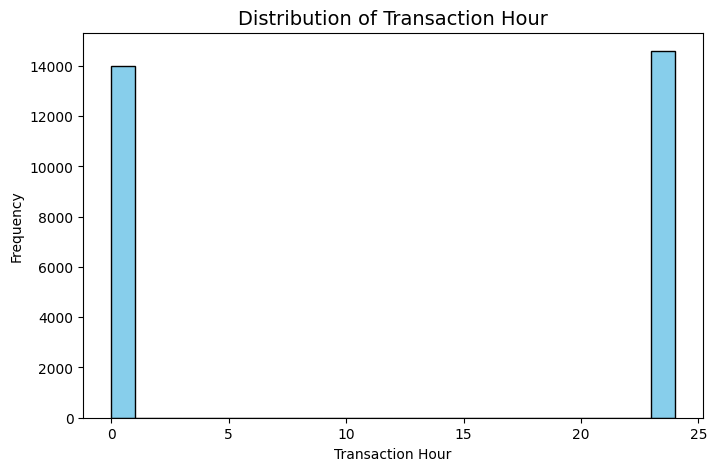

In [ ]:
# Histogram of Transaction Hour
plt.figure(figsize=(8, 5))
plt.hist(balanced_data['TransactionHour'], bins=24, color='skyblue', edgecolor='black')
plt.title('Distribution of Transaction Hour', fontsize=14)
plt.xlabel('Transaction Hour')
plt.ylabel('Frequency')
plt.show()

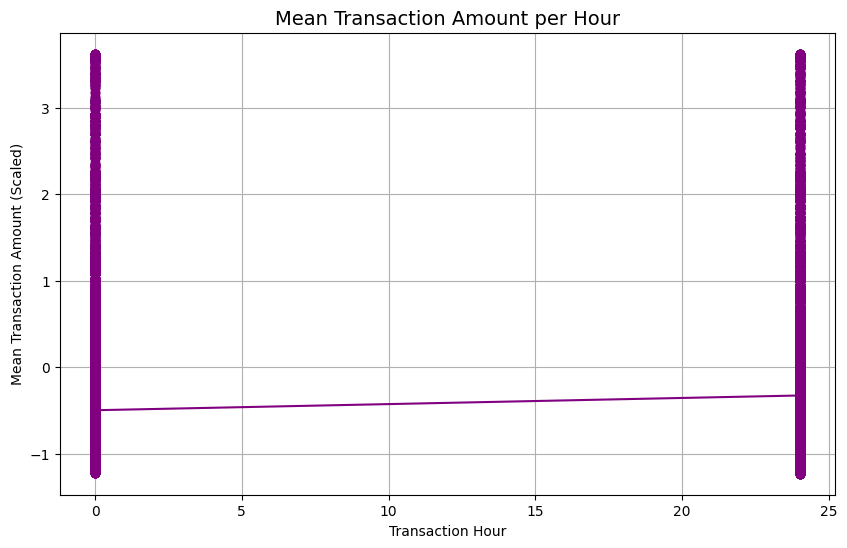

In [ ]:
# Line plot of Mean Transaction Amount per Hour
mean_transaction_per_hour = balanced_data.groupby('TransactionHour')['TransactionAmt'].mean()
plt.figure(figsize=(10, 6))
plt.plot(mean_transaction_per_hour.index, mean_transaction_per_hour.values, marker='o', linestyle='-', color='purple')
plt.title('Mean Transaction Amount per Hour', fontsize=14)
plt.xlabel('Transaction Hour')
plt.ylabel('Mean Transaction Amount (Scaled)')
plt.grid(True)
plt.show()

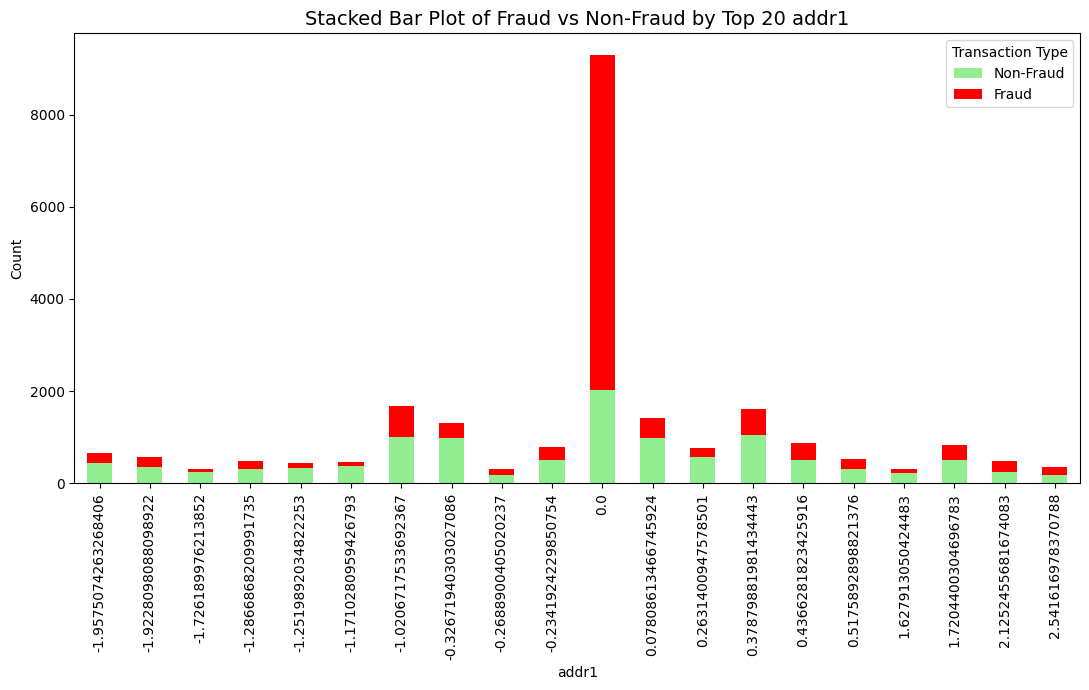

In [ ]:
# Function to plot stacked bar chart for top N categories of a feature
def plot_top_n_stacked_bar(df, feature, top_n=10):
    if feature in df.columns:
        # Get the top N categories by count
        top_n_values = df[feature].value_counts().nlargest(top_n).index

        # Filter the dataset to include only the top N categories
        filtered_df = df[df[feature].isin(top_n_values)]

        # Group by the feature and 'isFraud', then plot the stacked bar chart
        fraud_by_feature = filtered_df.groupby([feature, 'isFraud']).size().unstack()
        fraud_by_feature.plot(kind='bar', stacked=True, figsize=(11, 7), color=['lightgreen', 'red'])
        plt.title(f'Stacked Bar Plot of Fraud vs Non-Fraud by Top {top_n} {feature}', fontsize=14)
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.legend(['Non-Fraud', 'Fraud'], title='Transaction Type')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'{feature}' column does not exist in the dataset. Please select another feature.")

# Usage
categorical_feature = 'addr1'
plot_top_n_stacked_bar(balanced_data, categorical_feature, top_n=20)  # Plot for top 20 categories of addr1

## Feature Engineering

In [ ]:
#  Time-based Feature Engineering
def extract_time_features(df):
    df['TransactionHour'] = (df['TransactionDT'] / 3600) % 24
    df['TransactionDay'] = (df['TransactionDT'] / (3600 * 24)) % 7
    df['TransactionWeek'] = (df['TransactionDT'] / (3600 * 24 * 7)) % 52

    print("Created time-based features: TransactionHour, TransactionDay, TransactionWeek.")
    return df

#Aggregated Features (historical features for each cardholder)
def create_aggregated_features(df):

    df['TransactionAmt_mean_card'] = df.groupby('card1')['TransactionAmt'].transform('mean')
    df['TransactionAmt_total_card'] = df.groupby('card1')['TransactionAmt'].transform('sum')
    df['TransactionAmt_count_card'] = df.groupby('card1')['TransactionAmt'].transform('count')

    print("Created aggregated features: TransactionAmt_mean_card, TransactionAmt_total_card, TransactionAmt_count_card.")
    return df

# Interaction Features (create interaction terms between numerical features)
def create_interaction_features(df):
    # Ratio of 'TransactionAmt' to the mean transaction amount for each cardholder
    df['Amt_to_mean_ratio'] = df['TransactionAmt'] / df['TransactionAmt_mean_card']

    print("Created interaction feature: Amt_to_mean_ratio (TransactionAmt / mean TransactionAmt for cardholder).")
    return df

# Categorical Feature Encoding (re-encode categorical features)
def encode_categorical_features(df):
    # Re-encode 'ProductCD' using One-Hot Encoding
    if 'ProductCD' in df.columns:
        df = pd.get_dummies(df, columns=['ProductCD'], drop_first=True)
        print("Re-encoded categorical feature: ProductCD using One-Hot Encoding.")
    else:
        print("ProductCD column not found, skipping One-Hot Encoding.")
    return df

# Apply the feature engineering functions to the merged balanced_data dataset
balanced_data = extract_time_features(balanced_data)
balanced_data = create_aggregated_features(balanced_data)
balanced_data = create_interaction_features(balanced_data)
balanced_data = encode_categorical_features(balanced_data)

# Verify the new features
print("Sample of balanced_data after feature engineering:")
balanced_data.head()

Created time-based features: TransactionHour, TransactionDay, TransactionWeek.
Created aggregated features: TransactionAmt_mean_card, TransactionAmt_total_card, TransactionAmt_count_card.
Created interaction feature: Amt_to_mean_ratio (TransactionAmt / mean TransactionAmt for cardholder).
ProductCD column not found, skipping One-Hot Encoding.
Sample of balanced_data after feature engineering:


TransactionID   isFraud  TransactionDT  TransactionAmt     card1     card2  \
0       1.646022 -0.984513       1.712413       -0.765049 -1.098880  0.923006   
2      -0.924561  1.015730      -0.992076        0.535188 -0.793425 -0.561849   
3      -1.451878 -0.984513      -1.367188        2.060710  0.152648  1.012610   
4       0.481980  1.015730       0.449134       -1.026391 -0.342147  1.275020   
5       1.126937  1.015730       1.150066       -0.404780 -0.533370 -1.566687   

      card3     card5     addr1    addr2  ...  M4_M2   M5_T   M6_T  \
0  1.454928  0.561337  0.000000  0.00000  ...   True   True  False   
2 -0.626402 -0.655699 -1.286687  0.17133  ...  False   True  False   
3 -0.626402  0.561337  0.378799  0.17133  ...  False   True  False   
4  1.454928 -0.655699  0.000000  0.00000  ...  False   True  False   
5 -0.626402  0.722077  1.720440  0.17133  ...  False  False   True   

   TransactionHour  TransactionDay  TransactionWeek  TransactionAmt_mean_card  \
0         0.000476        0.000020     2.831371e-06                 -0.446962   
2        23.999724        6.999989     5.200000e+01                 -0.314327   
3        23.999620        6.999984     5.200000e+01                  0.642360   
4         0.000125        0.000005     7.426164e-07                 -0.989717   
5         0.000319        0.000013     1.901564e-06                  0.041875   

   TransactionAmt_total_card  TransactionAmt_count_card  Amt_to_mean_ratio  
0                 -93.415016                        209           1.711666  
2                  -2.828944                          9          -1.702646  
3                  37.899227                         59           3.208030  
4                  -1.979434                          2           1.037055  
5                   4.648122                        111          -9.666390  

[5 rows x 236 columns]

In [ ]:
balanced_data[['Amt_to_mean_ratio', 'TransactionAmt_count_card']].describe()

Amt_to_mean_ratio  TransactionAmt_count_card
count       28578.000000               28578.000000
mean            1.000000                 174.022535
std            54.207927                 223.451150
min         -4707.912444                   1.000000
25%            -0.710870                  15.000000
50%             1.000000                  73.000000
75%             1.944754                 251.000000
max          2408.354641                 819.000000

In [ ]:
balanced_data[['Amt_to_mean_ratio', 'TransactionAmt_count_card']].head()

Amt_to_mean_ratio  TransactionAmt_count_card
0           1.711666                        209
2          -1.702646                          9
3           3.208030                         59
4           1.037055                          2
5          -9.666390                        111

In [ ]:
# Checking Amt_to_mean_ratio
print("Amt_to_mean_ratio statistics:")
balanced_data['Amt_to_mean_ratio'].describe()

Amt_to_mean_ratio statistics:


count    28578.000000
mean         1.000000
std         54.207927
min      -4707.912444
25%         -0.710870
50%          1.000000
75%          1.944754
max       2408.354641
Name: Amt_to_mean_ratio, dtype: float64

In [ ]:
# Checking TransactionAmt_count_card
print("\nTransactionAmt_count_card statistics:")
balanced_data['TransactionAmt_count_card'].describe()


TransactionAmt_count_card statistics:


count    28578.000000
mean       174.022535
std        223.451150
min          1.000000
25%         15.000000
50%         73.000000
75%        251.000000
max        819.000000
Name: TransactionAmt_count_card, dtype: float64

In [ ]:
# Checking if there are any missing or zero values in both columns
print("\nNumber of NaN values in Amt_to_mean_ratio:", balanced_data['Amt_to_mean_ratio'].isna().sum())
print("Number of NaN values in TransactionAmt_count_card:", balanced_data['TransactionAmt_count_card'].isna().sum())
print("\nNumber of zero values in Amt_to_mean_ratio:", (balanced_data['Amt_to_mean_ratio'] == 0).sum())
print("Number of zero values in TransactionAmt_count_card:", (balanced_data['TransactionAmt_count_card'] == 0).sum())


Number of NaN values in Amt_to_mean_ratio: 0
Number of NaN values in TransactionAmt_count_card: 0

Number of zero values in Amt_to_mean_ratio: 0
Number of zero values in TransactionAmt_count_card: 0


In [ ]:
if 'card1' in balanced_data.columns:
    print("card1 column found!")
else:
    print("card1 column not found. Check if the data is loaded correctly.")

card1 column found!


In [ ]:
# Aggregated features with fallback values to handle missing data
balanced_data['TransactionAmt_mean_card'] = balanced_data.groupby('card1')['TransactionAmt'].transform('mean').fillna(0)
balanced_data['TransactionAmt_total_card'] = balanced_data.groupby('card1')['TransactionAmt'].transform('sum').fillna(0)
balanced_data['TransactionAmt_count_card'] = balanced_data.groupby('card1')['TransactionAmt'].transform('count').fillna(0)

# Interaction feature with fallback for division by zero
balanced_data['Amt_to_mean_ratio'] = balanced_data['TransactionAmt'] / balanced_data['TransactionAmt_mean_card']
balanced_data['Amt_to_mean_ratio'].replace([np.inf, -np.inf], 0, inplace=True)  # Handle division by zero
balanced_data['Amt_to_mean_ratio'].fillna(0, inplace=True)

In [ ]:
# Verify that the new features have non-zero values
print("\nAfter recalculation:")
balanced_data[['Amt_to_mean_ratio', 'TransactionAmt_count_card']].describe()


After recalculation:


Amt_to_mean_ratio  TransactionAmt_count_card
count       28578.000000               28578.000000
mean            1.000000                 174.022535
std            54.207927                 223.451150
min         -4707.912444                   1.000000
25%            -0.710870                  15.000000
50%             1.000000                  73.000000
75%             1.944754                 251.000000
max          2408.354641                 819.000000

In [ ]:
# Check for NaN or zero values after recalculation
print("\nNumber of NaN values in Amt_to_mean_ratio:", balanced_data['Amt_to_mean_ratio'].isna().sum())
print("Number of NaN values in TransactionAmt_count_card:", balanced_data['TransactionAmt_count_card'].isna().sum())
print("\nNumber of zero values in Amt_to_mean_ratio:", (balanced_data['Amt_to_mean_ratio'] == 0).sum())
print("Number of zero values in TransactionAmt_count_card:", (balanced_data['TransactionAmt_count_card'] == 0).sum())


Number of NaN values in Amt_to_mean_ratio: 0
Number of NaN values in TransactionAmt_count_card: 0

Number of zero values in Amt_to_mean_ratio: 0
Number of zero values in TransactionAmt_count_card: 0


In [ ]:
balanced_data['Amt_to_mean_ratio'].fillna(0, inplace=True)
balanced_data['TransactionAmt_count_card'].fillna(0, inplace=True)

In [ ]:
# Check if 'isFraud' column contains both 0 and 1 values
print("Unique values in 'isFraud' column:")
print(balanced_data['isFraud'].unique())

# Check for NaN values in Amt_to_mean_ratio and TransactionAmt_count_card
print("\nNumber of NaN values in 'Amt_to_mean_ratio':")
print(balanced_data['Amt_to_mean_ratio'].isna().sum())

print("\nNumber of NaN values in 'TransactionAmt_count_card':")
print(balanced_data['TransactionAmt_count_card'].isna().sum())

Unique values in 'isFraud' column:
[-0.98451349  1.01573011]

Number of NaN values in 'Amt_to_mean_ratio':
0

Number of NaN values in 'TransactionAmt_count_card':
0


In [ ]:
# Check some basic statistics for these columns
print("\nBasic statistics for 'Amt_to_mean_ratio':")
balanced_data['Amt_to_mean_ratio'].describe()


Basic statistics for 'Amt_to_mean_ratio':


count    28578.000000
mean         1.000000
std         54.207927
min      -4707.912444
25%         -0.710870
50%          1.000000
75%          1.944754
max       2408.354641
Name: Amt_to_mean_ratio, dtype: float64

In [ ]:
print("\nBasic statistics for 'TransactionAmt_count_card':")
balanced_data['TransactionAmt_count_card'].describe()


Basic statistics for 'TransactionAmt_count_card':


count    28578.000000
mean       174.022535
std        223.451150
min          1.000000
25%         15.000000
50%         73.000000
75%        251.000000
max        819.000000
Name: TransactionAmt_count_card, dtype: float64

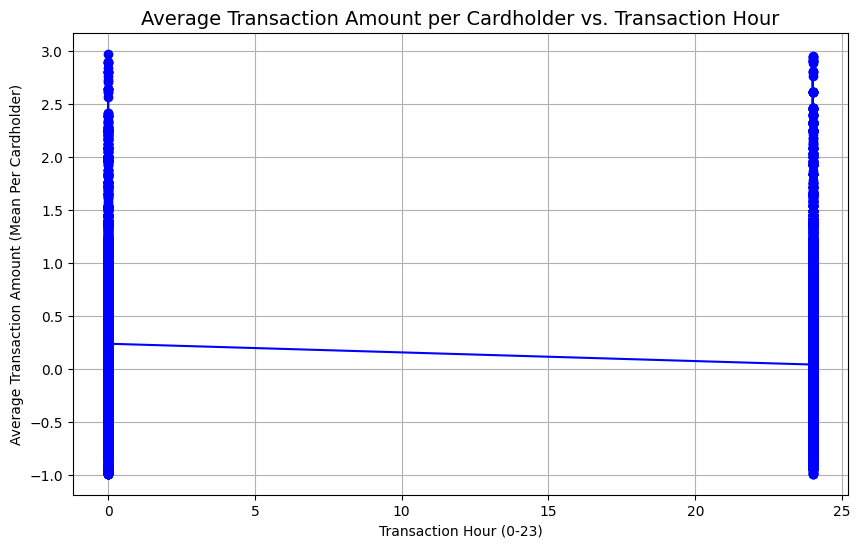

In [ ]:
# Filter out extreme values for better visualization (focus on values between -1 and 3)
filtered_data = balanced_data[(balanced_data['TransactionAmt_mean_card'] > -1) &
                              (balanced_data['TransactionAmt_mean_card'] < 3)]

# Line plot of average transaction amount per cardholder vs. transaction hour
plt.figure(figsize=(10, 6))
avg_amt_per_hour = filtered_data.groupby('TransactionHour')['TransactionAmt_mean_card'].mean()
plt.plot(avg_amt_per_hour.index, avg_amt_per_hour.values, marker='o', linestyle='-', color='b')

plt.title('Average Transaction Amount per Cardholder vs. Transaction Hour', fontsize=14)
plt.xlabel('Transaction Hour (0-23)')
plt.ylabel('Average Transaction Amount (Mean Per Cardholder)')
plt.grid(True)
plt.show()

In [ ]:
# Check for missing or zero values in the Amt_to_mean_ratio column
print("Amt_to_mean_ratio statistics:")
balanced_data['Amt_to_mean_ratio'].describe()

Amt_to_mean_ratio statistics:


count    28578.000000
mean         1.000000
std         54.207927
min      -4707.912444
25%         -0.710870
50%          1.000000
75%          1.944754
max       2408.354641
Name: Amt_to_mean_ratio, dtype: float64

In [ ]:
print("\nNumber of NaN values in Amt_to_mean_ratio:", balanced_data['Amt_to_mean_ratio'].isna().sum())
print("Number of zero values in Amt_to_mean_ratio:", (balanced_data['Amt_to_mean_ratio'] == 0).sum())


Number of NaN values in Amt_to_mean_ratio: 0
Number of zero values in Amt_to_mean_ratio: 0


In [ ]:
# Filter out extreme outliers for better visualization (focus on values between -100 and 100)
filtered_amt_to_mean_ratio = balanced_data[(balanced_data['Amt_to_mean_ratio'] > -100) &
                                           (balanced_data['Amt_to_mean_ratio'] < 100)]

In [ ]:
# Check if the filtering results in any data
print(f"Filtered data shape: {filtered_amt_to_mean_ratio.shape}")
print("Sample of filtered data:")
filtered_amt_to_mean_ratio[['Amt_to_mean_ratio', 'isFraud']].head()

Filtered data shape: (28406, 236)
Sample of filtered data:


Amt_to_mean_ratio   isFraud
0           1.711666 -0.984513
2          -1.702646  1.015730
3           3.208030 -0.984513
4           1.037055  1.015730
5          -9.666390  1.015730

In [ ]:
# Check unique values in 'isFraud'
print("Unique values in 'isFraud':", filtered_amt_to_mean_ratio['isFraud'].unique())

# If 'isFraud' is scaled, revert it to binary form
if filtered_amt_to_mean_ratio['isFraud'].min() < 0:
    print("Reverting scaled 'isFraud' to binary values.")
    filtered_amt_to_mean_ratio['isFraud'] = filtered_amt_to_mean_ratio['isFraud'].apply(lambda x: 1 if x > 0 else 0)

Unique values in 'isFraud': [-0.98451349  1.01573011]
Reverting scaled 'isFraud' to binary values.


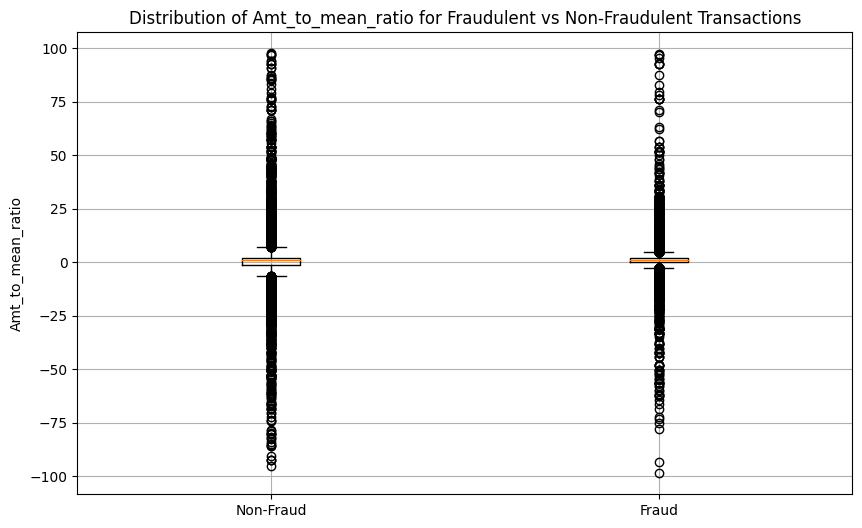

In [ ]:
plt.figure(figsize=(10, 6))

# Create boxplots for Amt_to_mean_ratio by fraud and non-fraud
plt.boxplot([filtered_amt_to_mean_ratio[filtered_amt_to_mean_ratio['isFraud'] == 0]['Amt_to_mean_ratio'],
             filtered_amt_to_mean_ratio[filtered_amt_to_mean_ratio['isFraud'] == 1]['Amt_to_mean_ratio']],
            labels=['Non-Fraud', 'Fraud'])

plt.title('Distribution of Amt_to_mean_ratio for Fraudulent vs Non-Fraudulent Transactions')
plt.ylabel('Amt_to_mean_ratio')
plt.grid(True)
plt.show()


In [ ]:
# Check for missing values in 'TransactionAmt_count_card'

print("Checking for NaN values in 'TransactionAmt_count_card':")
print(balanced_data['TransactionAmt_count_card'].isna().sum())

print("\nChecking the number of Non-Fraud and Fraud entries:")
print("Non-Fraud entries:", balanced_data[balanced_data['isFraud'] == 0].shape[0])
print("Fraud entries:", balanced_data[balanced_data['isFraud'] == 1].shape[0])

# Ensure valid means and standard deviations (set to 0 if no entries)
if balanced_data[balanced_data['isFraud'] == 0].shape[0] == 0:
    avg_count_non_fraud = 0
    std_count_non_fraud = 0
else:
    avg_count_non_fraud = balanced_data[balanced_data['isFraud'] == 0]['TransactionAmt_count_card'].mean()
    std_count_non_fraud = balanced_data[balanced_data['isFraud'] == 0]['TransactionAmt_count_card'].std()

if balanced_data[balanced_data['isFraud'] == 1].shape[0] == 0:
    avg_count_fraud = 0
    std_count_fraud = 0
else:
    avg_count_fraud = balanced_data[balanced_data['isFraud'] == 1]['TransactionAmt_count_card'].mean()
    std_count_fraud = balanced_data[balanced_data['isFraud'] == 1]['TransactionAmt_count_card'].std()

Checking for NaN values in 'TransactionAmt_count_card':
0

Checking the number of Non-Fraud and Fraud entries:
Non-Fraud entries: 0
Fraud entries: 0


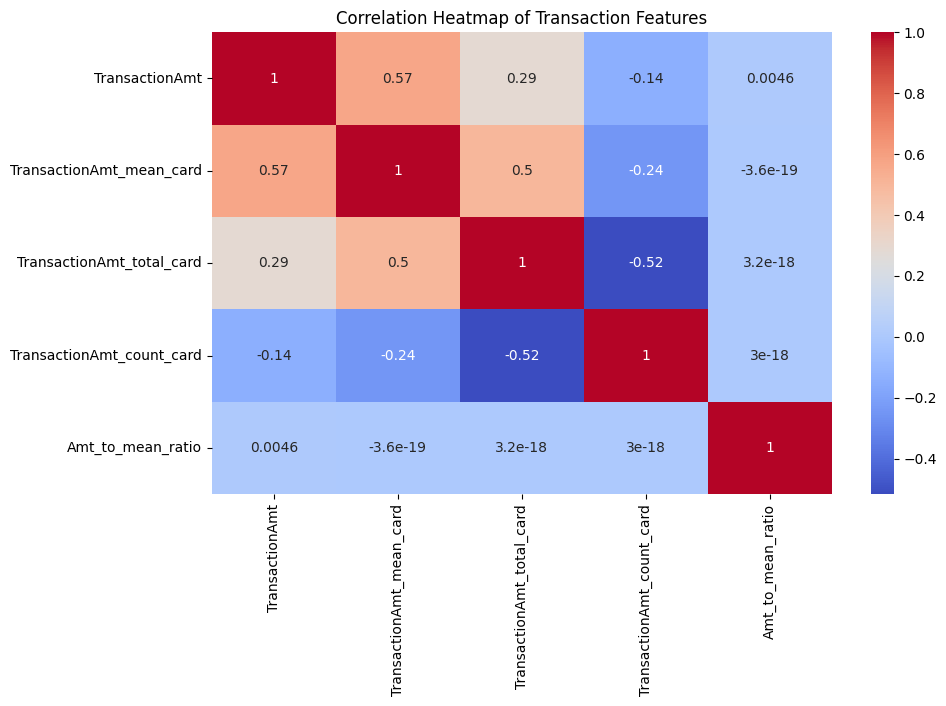

In [ ]:
# Compute the correlation matrix
correlation_matrix = balanced_data[['TransactionAmt', 'TransactionAmt_mean_card', 'TransactionAmt_total_card', 'TransactionAmt_count_card', 'Amt_to_mean_ratio']].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Transaction Features')
plt.show()

##Principal Component Analysis

In [ ]:
# Apply PCA to the dataset (balanced_data)
def apply_pca(df, n_components=None):
    # Select only the numerical columns for PCA (excluding 'isFraud')
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numerical_cols = numerical_cols.drop('isFraud', errors='ignore')

    # Standardize the numerical data before PCA
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numerical_cols])

    # Initialize the PCA model
    pca = PCA(n_components=n_components)

    # Fit and transform the scaled numerical data
    pca_result = pca.fit_transform(scaled_data)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    # Append the target column ('isFraud') for future use
    pca_df['isFraud'] = df['isFraud'].reset_index(drop=True)

    # Explained variance by each principal component
    explained_variance = pca.explained_variance_ratio_

    print(f"Explained variance ratio by each component: {explained_variance}")
    return pca_df, explained_variance

#  Apply PCA with a predefined number of components (2 in this case)
pca_data, explained_variance = apply_pca(balanced_data, n_components=2)

Explained variance ratio by each component: [0.18142861 0.08812394]


Unique values in 'isFraud': [-0.98451349  1.01573011]
Reverting 'isFraud' to binary values...
Explained variance ratio by each component: [0.18142861 0.08812394]
PCA Component Ranges:
                PC1           PC2
count  2.857800e+04  2.857800e+04
mean   2.659376e-15 -1.939336e-16
std    6.289103e+00  4.383114e+00
min   -2.164156e+01 -3.510147e+00
25%   -4.588060e+00 -1.461933e+00
50%   -3.710703e+00 -8.758213e-01
75%    7.154072e+00  3.782934e-01
max    3.045162e+01  3.513048e+02


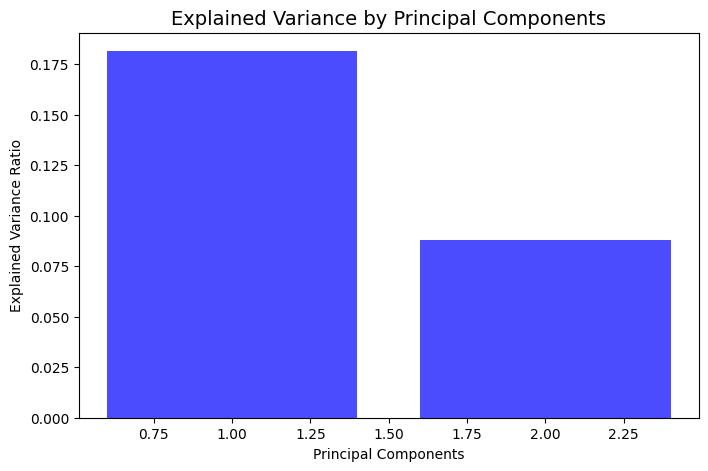

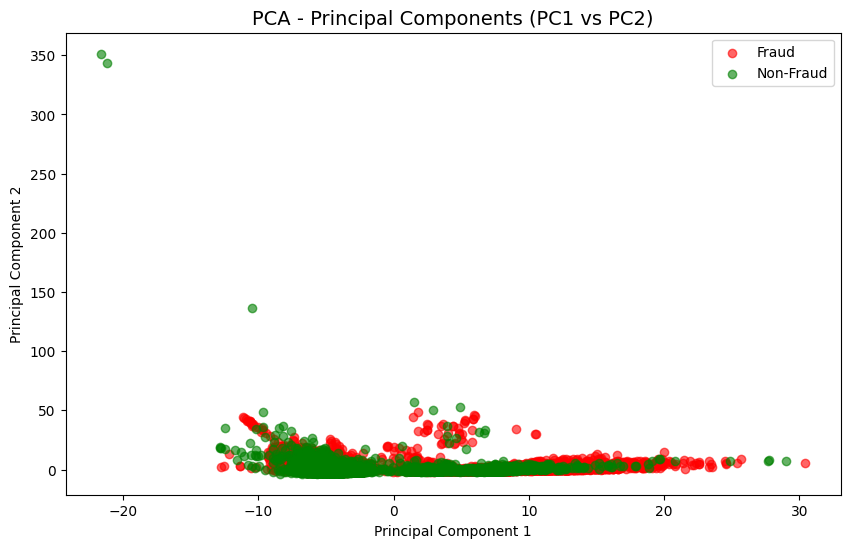

In [ ]:
# PCA Visualization Functions

# Visualize explained variance to understand how much variance is captured
def plot_explained_variance(explained_variance):
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', color='blue')
    plt.title('Explained Variance by Principal Components', fontsize=14)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.show()

# Scatter plot of the first two principal components to visualize fraud vs non-fraud
def plot_pca_components(pca_df):
    plt.figure(figsize=(10, 6))

    # Scatter plot of PC1 vs PC2, coloring based on the target variable 'isFraud'
    fraud = pca_df[pca_df['isFraud'] == 1]
    non_fraud = pca_df[pca_df['isFraud'] == 0]

    plt.scatter(fraud['PC1'], fraud['PC2'], color='red', label='Fraud', alpha=0.6)
    plt.scatter(non_fraud['PC1'], non_fraud['PC2'], color='green', label='Non-Fraud', alpha=0.6)

    plt.title('PCA - Principal Components (PC1 vs PC2)', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Apply PCA to the dataset (balanced_data)
def apply_pca(df, n_components=None):
    # Ensure the 'isFraud' column is binary (0 and 1) and not scaled
    print("Unique values in 'isFraud':", df['isFraud'].unique())
    if df['isFraud'].min() < 0:
        print("Reverting 'isFraud' to binary values...")
        df['isFraud'] = df['isFraud'].apply(lambda x: 1 if x > 0 else 0)

    # Select only the numerical columns for PCA (excluding 'isFraud')
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numerical_cols = numerical_cols.drop('isFraud', errors='ignore')

    # Standardize the numerical data before PCA
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numerical_cols])

    # Initialize the PCA model
    pca = PCA(n_components=n_components)

    # Fit and transform the scaled numerical data
    pca_result = pca.fit_transform(scaled_data)

    # Create a DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

    # Append the target column ('isFraud') for future use
    pca_df['isFraud'] = df['isFraud'].reset_index(drop=True)

    # Explained variance by each principal component
    explained_variance = pca.explained_variance_ratio_

    print(f"Explained variance ratio by each component: {explained_variance}")

    # Check the PCA result ranges to ensure meaningful values
    print("PCA Component Ranges:")
    print(pca_df[['PC1', 'PC2']].describe())

    return pca_df, explained_variance

# Apply PCA with 2 components
pca_data, explained_variance = apply_pca(balanced_data, n_components=2)

# Plot the explained variance
plot_explained_variance(explained_variance)

# Plot the first two principal components
plot_pca_components(pca_data)

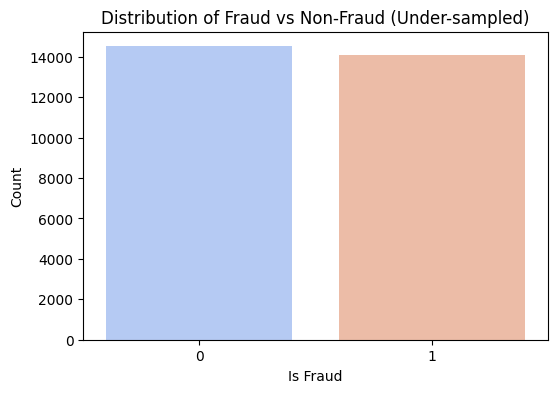

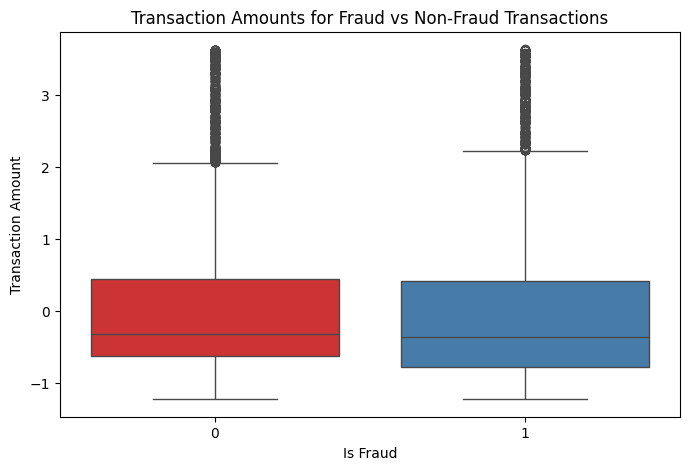

In [ ]:
# Visualizations for Fraud vs Non-Fraud (Already Under-sampled Data)

plt.figure(figsize=(6, 4))
sns.countplot(x=balanced_data['isFraud'], palette='coolwarm')
plt.title('Distribution of Fraud vs Non-Fraud (Under-sampled)')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# Boxplot to compare Transaction Amounts for Fraud vs Non-Fraud transactions
plt.figure(figsize=(8, 5))
sns.boxplot(x='isFraud', y='TransactionAmt', data=balanced_data, palette='Set1')
plt.title('Transaction Amounts for Fraud vs Non-Fraud Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()

In [ ]:
print(balanced_data.columns)

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'M4_M2', 'M5_T', 'M6_T', 'TransactionHour', 'TransactionDay',
       'TransactionWeek', 'TransactionAmt_mean_card',
       'TransactionAmt_total_card', 'TransactionAmt_count_card',
       'Amt_to_mean_ratio'],
      dtype='object', length=236)


##Training-Testing Split

In [ ]:
# Define the feature set (X) and target variable (y) using the balanced dataset
X = balanced_data.drop(columns=['isFraud'])
y = balanced_data['isFraud']

# Split the data into training and testing sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Output the shapes of the resulting datasets
print("Training feature set shape:", X_train.shape)
print("Testing feature set shape:", X_test.shape)
print("Training target set shape:", y_train.shape)
print("Testing target set shape:", y_test.shape)

# Check the distribution of the target variable in the training and test sets
print("\nDistribution of target in the training set:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of target in the testing set:")
print(y_test.value_counts(normalize=True))

Training feature set shape: (22862, 235)
Testing feature set shape: (5716, 235)
Training target set shape: (22862,)
Testing target set shape: (5716,)

Distribution of target in the training set:
isFraud
0    0.507786
1    0.492214
Name: proportion, dtype: float64

Distribution of target in the testing set:
isFraud
0    0.507873
1    0.492127
Name: proportion, dtype: float64


In [ ]:
# Check for any remaining object columns (categorical data)
print("Checking data types before encoding:")
print(X_train.dtypes[X_train.dtypes == 'object'])

# Print a few examples of the problematic column values
for col in X_train.select_dtypes(include=['object']).columns:
    print(f"Sample unique values in '{col}': {X_train[col].unique()[:5]}")

# Check for categorical data types that are not 'object'
print("Checking for Categorical dtypes:")
print(X_train.select_dtypes(include=['category']).head())

Checking data types before encoding:
Series([], dtype: object)
Checking for Categorical dtypes:
Empty DataFrame
Columns: []
Index: [3994, 32488, 19730, 38740, 34806]


In [ ]:
# Apply Label Encoding for binary columns, and One-Hot Encoding for multi-class columns
def encode_categorical_columns(df, categorical_cols):
    # Iterate over each categorical column
    for col in categorical_cols:
        if df[col].nunique() <= 2:
            # Use LabelEncoder for binary columns
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            print(f"Applied Label Encoding to binary column: {col}")
        else:
            # Use One-Hot Encoding for columns with more than 2 unique values
            onehot_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, onehot_encoded], axis=1)
            df.drop(columns=[col], inplace=True)
            print(f"Applied One-Hot Encoding to column: {col}")

    return df

In [ ]:
# Automatically detect categorical columns
def detect_categorical_columns(df):
    # Select columns with dtype 'object' or columns with a small number of unique values
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    low_cardinality_cols = [col for col in df.columns if df[col].nunique() <= 10 and col not in categorical_cols]
    return categorical_cols + low_cardinality_cols

# Encoding function
def encode_categorical_columns(df, categorical_cols):
    # Iterate over each categorical column
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() <= 2:
                # Use LabelEncoder for binary columns
                le = LabelEncoder()
                df[col] = le.fit_transform(df[col].astype(str))
                print(f"Applied Label Encoding to binary column: {col}")
            else:
                # Use One-Hot Encoding for columns with more than 2 unique values
                onehot_encoded = pd.get_dummies(df[col], prefix=col, drop_first=True)
                df = pd.concat([df, onehot_encoded], axis=1)
                df.drop(columns=[col], inplace=True)
                print(f"Applied One-Hot Encoding to column: {col}")
        else:
            print(f"Column '{col}' not found in the dataframe. Skipping encoding for this column.")

    return df

# Automatically detect categorical columns in the training set
categorical_cols_transaction = detect_categorical_columns(X_train)

# Apply encoding to both training and test sets
X_train = encode_categorical_columns(X_train, categorical_cols_transaction)
X_test = encode_categorical_columns(X_test, categorical_cols_transaction)

# Verify no categorical columns are left
print("Remaining categorical columns after encoding:", X_train.dtypes[X_train.dtypes == 'object'])

# Output final shapes after encoding
print("Final training set shape:", X_train.shape)
print("Final test set shape:", X_test.shape)

Applied One-Hot Encoding to column: addr2
Applied One-Hot Encoding to column: C3
Applied One-Hot Encoding to column: V1
Applied One-Hot Encoding to column: V2
Applied One-Hot Encoding to column: V3
Applied One-Hot Encoding to column: V4
Applied One-Hot Encoding to column: V5
Applied One-Hot Encoding to column: V6
Applied One-Hot Encoding to column: V7
Applied One-Hot Encoding to column: V8
Applied One-Hot Encoding to column: V9
Applied One-Hot Encoding to column: V10
Applied One-Hot Encoding to column: V11
Applied One-Hot Encoding to column: V12
Applied One-Hot Encoding to column: V13
Applied One-Hot Encoding to column: V14
Applied One-Hot Encoding to column: V15
Applied One-Hot Encoding to column: V16
Applied One-Hot Encoding to column: V19
Applied One-Hot Encoding to column: V20
Applied One-Hot Encoding to column: V21
Applied One-Hot Encoding to column: V22
Applied One-Hot Encoding to column: V25
Applied One-Hot Encoding to column: V26
Applied One-Hot Encoding to column: V27
Applied 

##Random Forest Model Evaluation

In [ ]:
# Ensure consistent encoding between X_train and X_test
def align_features(train, test):
    # Align the test dataset to have the same columns as the train dataset
    test_aligned = test.reindex(columns=train.columns, fill_value=0)
    return train, test_aligned

# Apply the function to align the features
X_train_aligned, X_test_aligned = align_features(X_train, X_test)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the aligned training data
rf_classifier.fit(X_train_aligned, y_train)

# 3. Make predictions on the aligned test data
y_pred = rf_classifier.predict(X_test_aligned)
y_prob = rf_classifier.predict_proba(X_test_aligned)[:, 1]  # Probabilities for ROC AUC

# Evaluate the model performance

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# ROC AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      2903
           1       0.88      0.81      0.84      2813

    accuracy                           0.85      5716
   macro avg       0.85      0.85      0.85      5716
weighted avg       0.85      0.85      0.85      5716

Accuracy: 0.8504
ROC AUC Score: 0.9241

Confusion Matrix:
 [[2589  314]
 [ 541 2272]]


In [ ]:
# Plot Confusion Matrix
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6,4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_test, y_prob, roc_auc):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# Plot Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_prob):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, color='b', label='Precision-Recall Curve')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=14)
    plt.grid(True)
    plt.show()

# Plot Top N Feature Importances
def plot_top_feature_importances(rf_classifier, X_train, N=10):
    importances = rf_classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:N]

    plt.figure(figsize=(10,6))
    plt.title(f'Top {N} Feature Importances', fontsize=16)
    plt.bar(range(N), importances[top_indices], align='center', color='skyblue')
    plt.xticks(range(N), X_train.columns[top_indices], rotation=90)
    plt.xlim([-1, N])
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot Cumulative Gain Chart
def plot_cumulative_gain_curve(y_test, y_prob):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    cumulative_gain = np.cumsum(tpr) / np.sum(tpr)

    plt.figure(figsize=(8,6))
    plt.plot(np.linspace(0, 1, len(cumulative_gain)), cumulative_gain, label='Cumulative Gain', color='green')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model', color='red')
    plt.title('Cumulative Gain Chart', fontsize=16)
    plt.xlabel('Fraction of Total Population', fontsize=12)
    plt.ylabel('Gain (True Positives)', fontsize=12)
    plt.legend(loc='lower right')
    plt.show()

# Plot Model Accuracy vs Benchmark
def plot_model_vs_benchmark_accuracy(model_accuracy, benchmark_accuracy=1.0):
    plt.figure(figsize=(6,4))
    plt.bar(['Model Accuracy', 'Benchmark'], [model_accuracy, benchmark_accuracy], color=['blue', 'green'])
    plt.ylim(0, 1.1)  # Set y-axis limit for better comparison
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Model Accuracy vs Benchmark', fontsize=16)
    plt.text(0, model_accuracy + 0.02, f'{model_accuracy:.2f}', ha='center', fontsize=12)
    plt.text(1, benchmark_accuracy + 0.02, f'{benchmark_accuracy:.2f}', ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

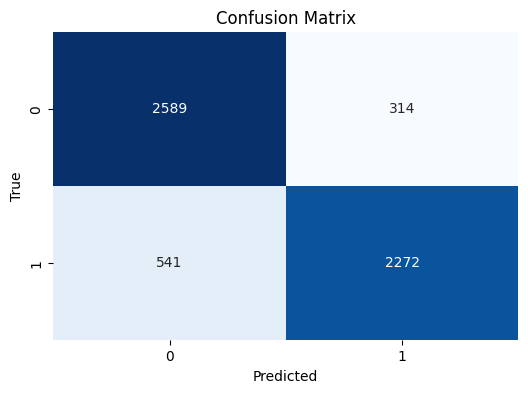

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix)

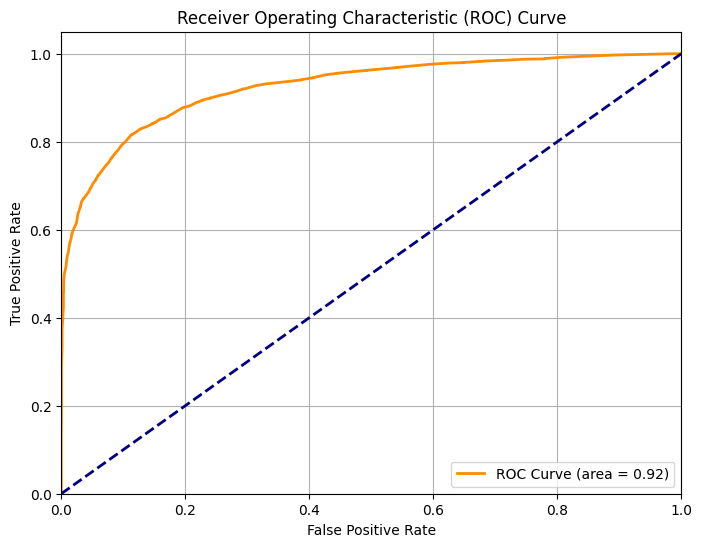

In [ ]:
# Plot ROC Curve
plot_roc_curve(y_test, y_prob, roc_auc)

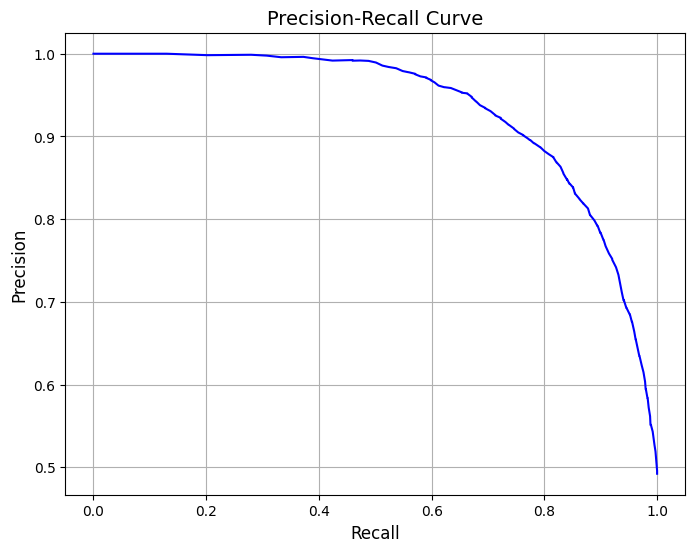

In [ ]:
# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test, y_prob)

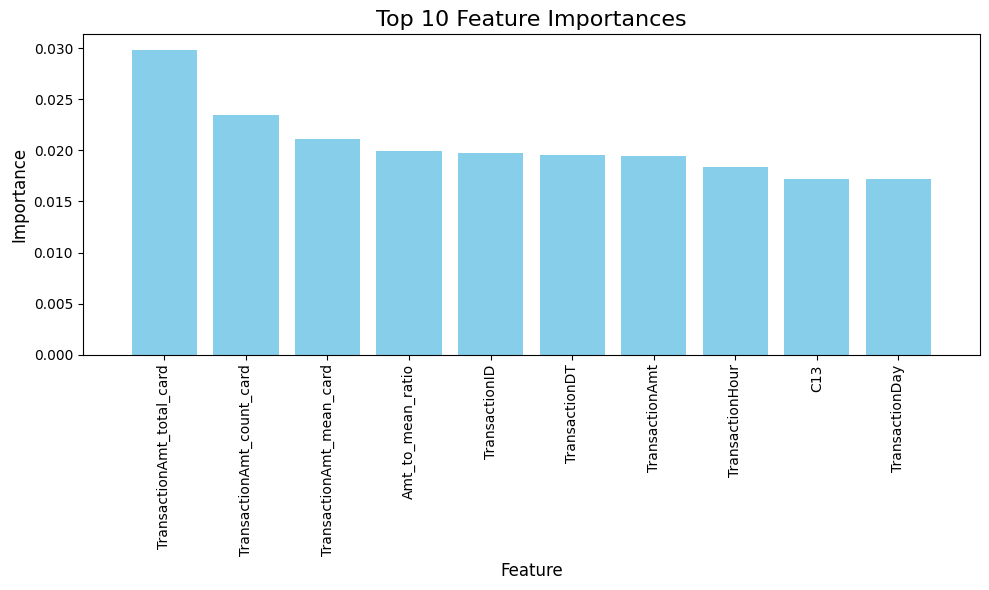

In [ ]:
# Plot Top N Feature Importances
plot_top_feature_importances(rf_classifier, X_train, N=10)

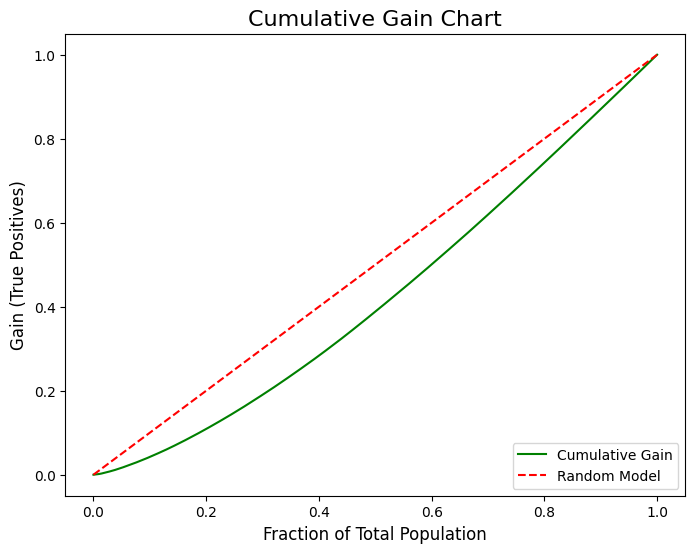

In [ ]:
# Plot Cumulative Gain Chart
plot_cumulative_gain_curve(y_test, y_prob)

##Isolation Forest Model Evaluation

In [ ]:
# Drop rows with any missing values in X_train and X_test
X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train.loc[X_train_cleaned.index]
X_test_cleaned = X_test.dropna()
y_test_cleaned = y_test.loc[X_test_cleaned.index]

#  Ensure both train and test sets have the same features
missing_cols_in_test = set(X_train_cleaned.columns) - set(X_test_cleaned.columns)
missing_cols_in_train = set(X_test_cleaned.columns) - set(X_train_cleaned.columns)

# Add missing columns in test set and train set as necessary
for col in missing_cols_in_test:
    X_test_cleaned[col] = 0
for col in missing_cols_in_train:
    X_train_cleaned[col] = 0

# Align the columns order
X_train_cleaned = X_train_cleaned[X_test_cleaned.columns]

# Initialize the Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Fit the model on the cleaned training data
isolation_forest.fit(X_train_cleaned)

# Predict the anomaly scores on the cleaned test data
y_pred_if = isolation_forest.predict(X_test_cleaned)

# Convert predictions
y_pred_if_binary = np.where(y_pred_if == -1, 1, 0)

# Evaluate the model's performance

# Classification report
print("Isolation Forest Classification Report:\n", classification_report(y_test_cleaned, y_pred_if_binary))

# Accuracy score
accuracy_if = accuracy_score(y_test_cleaned, y_pred_if_binary)
print(f"Accuracy (Isolation Forest): {accuracy_if:.4f}")

# Confusion matrix
conf_matrix_if = confusion_matrix(y_test_cleaned, y_pred_if_binary)
print("\nConfusion Matrix (Isolation Forest):\n", conf_matrix_if)

# ROC AUC score (for binary predictions)
roc_auc_if = roc_auc_score(y_test_cleaned, y_pred_if_binary)
print(f"ROC AUC Score (Isolation Forest): {roc_auc_if:.4f}")

Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68      2903
           1       0.86      0.06      0.11      2813

    accuracy                           0.53      5716
   macro avg       0.69      0.53      0.40      5716
weighted avg       0.69      0.53      0.40      5716

Accuracy (Isolation Forest): 0.5327

Confusion Matrix (Isolation Forest):
 [[2875   28]
 [2643  170]]
ROC AUC Score (Isolation Forest): 0.5254


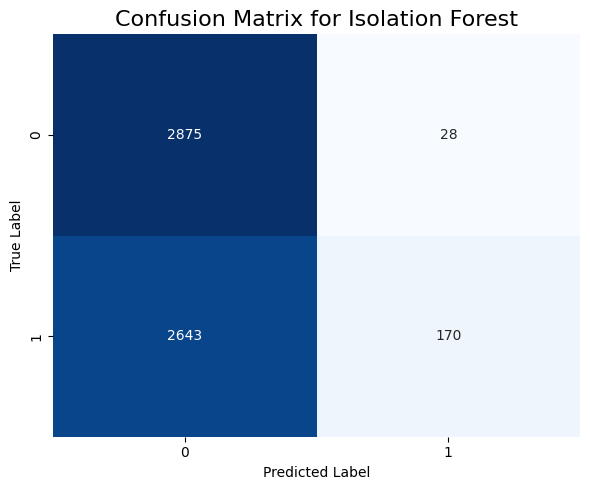

In [ ]:
# Plot Confusion Matrix
conf_matrix_if = confusion_matrix(y_test_cleaned, y_pred_if_binary)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_if, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix for Isolation Forest', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

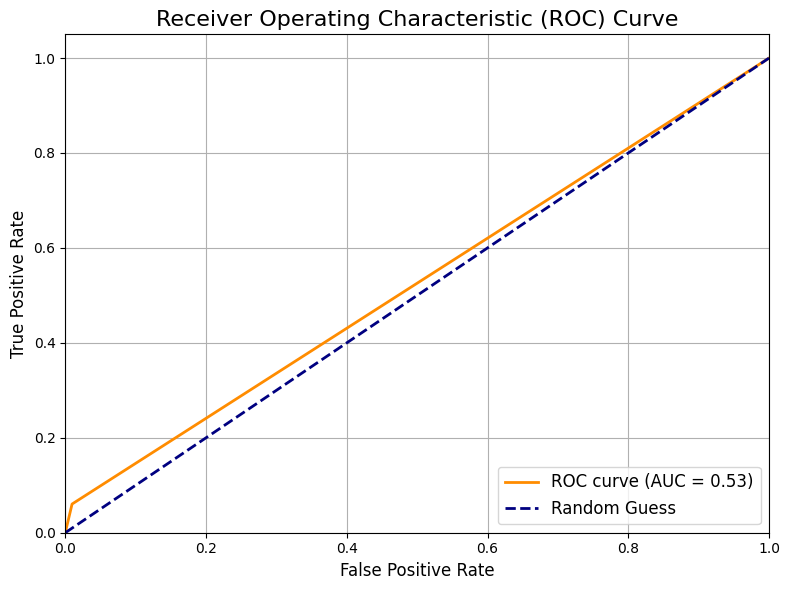

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_cleaned, y_pred_if_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

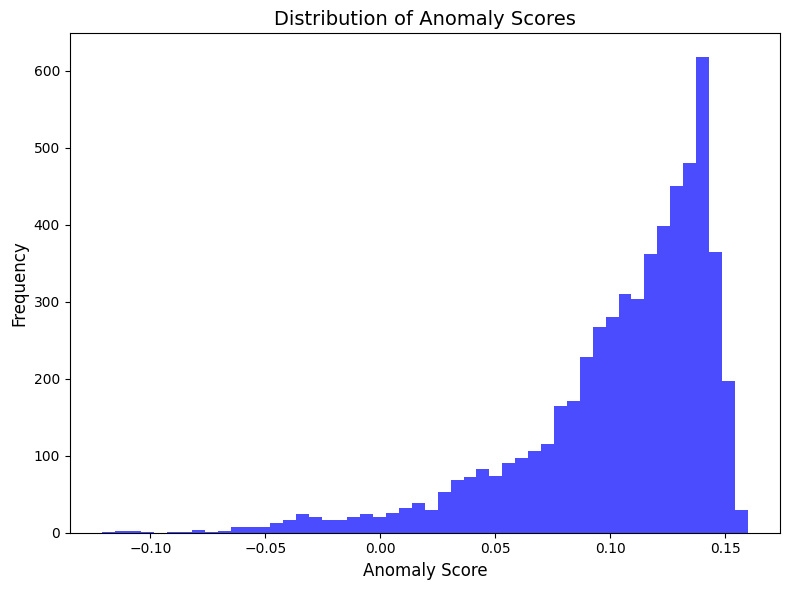

In [ ]:
# Distribution of Anomaly Scores
anomaly_scores = isolation_forest.decision_function(X_test_cleaned)

plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Anomaly Scores', fontsize=14)
plt.xlabel('Anomaly Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

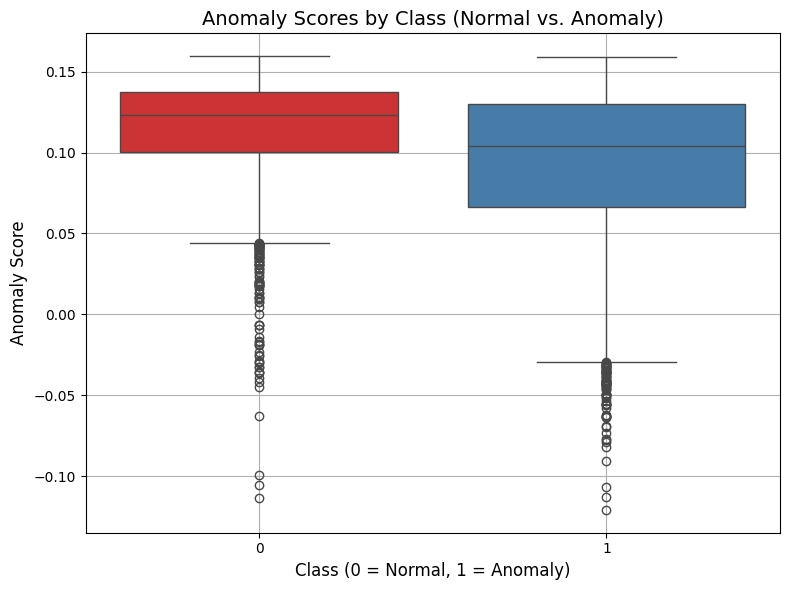

In [ ]:
# Boxplot of Anomaly Scores by Class
anomaly_score_df = pd.DataFrame({'Anomaly Score': anomaly_scores, 'Class': y_test_cleaned})

plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='Anomaly Score', data=anomaly_score_df, palette='Set1')
plt.title('Anomaly Scores by Class (Normal vs. Anomaly)', fontsize=14)
plt.xlabel('Class (0 = Normal, 1 = Anomaly)', fontsize=12)
plt.ylabel('Anomaly Score', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

##Hybrid Model (RF+IF)

In [ ]:
# Initialize the models
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
isolation_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

# Train the Random Forest model on the training data
random_forest.fit(X_train_cleaned, y_train_cleaned)

# Train the Isolation Forest model on the training data
isolation_forest.fit(X_train_cleaned)

# Make predictions on the test data
y_pred_rf = random_forest.predict(X_test_cleaned)

# Predict anomaly scores using Isolation Forest and convert to binary predictions
y_pred_if = isolation_forest.predict(X_test_cleaned)

y_pred_if_binary = np.where(y_pred_if == -1, 1, 0)

# Stack predictions from both models as features for the hybrid model
stacked_predictions = np.column_stack((y_pred_rf, y_pred_if_binary))

# Train a Logistic Regression model as the final hybrid classifier
hybrid_model = LogisticRegression(random_state=42)
hybrid_model.fit(stacked_predictions, y_test_cleaned)

# Make predictions with the hybrid model
final_pred = hybrid_model.predict(stacked_predictions)

# Evaluate the hybrid model performance

# Classification report
print("Hybrid Model Classification Report:\n", classification_report(y_test_cleaned, final_pred))

# Accuracy score
accuracy_hybrid = accuracy_score(y_test_cleaned, final_pred)
print(f"Accuracy (Hybrid Model): {accuracy_hybrid:.4f}")

# Confusion matrix
conf_matrix_hybrid = confusion_matrix(y_test_cleaned, final_pred)
print("\nConfusion Matrix (Hybrid Model):\n", conf_matrix_hybrid)

# ROC AUC Score for the Hybrid Model
y_pred_proba = hybrid_model.predict_proba(stacked_predictions)[:, 1]
roc_auc_hybrid = roc_auc_score(y_test_cleaned, y_pred_proba)
print(f"ROC AUC Score (Hybrid Model): {roc_auc_hybrid:.4f}")

Hybrid Model Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2903
           1       0.87      0.80      0.83      2813

    accuracy                           0.84      5716
   macro avg       0.84      0.84      0.84      5716
weighted avg       0.84      0.84      0.84      5716

Accuracy (Hybrid Model): 0.8410

Confusion Matrix (Hybrid Model):
 [[2568  335]
 [ 574 2239]]
ROC AUC Score (Hybrid Model): 0.8418


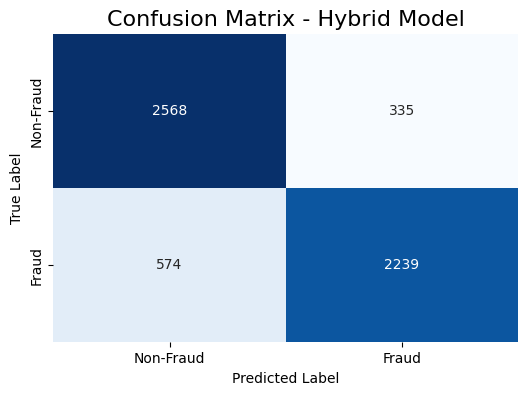

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test_cleaned, final_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Hybrid Model', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

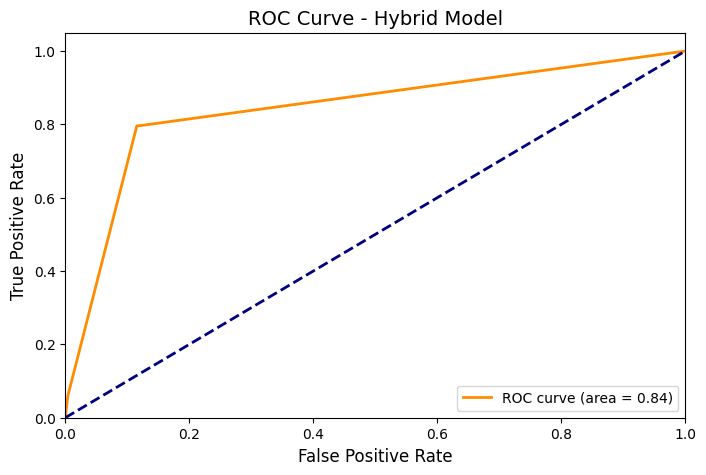

In [ ]:
# ROC Curve for the Hybrid Model
# Get probability scores for the hybrid model predictions
final_pred_prob = hybrid_model.predict_proba(stacked_predictions)[:, 1]

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test_cleaned, final_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hybrid Model', fontsize=14)
plt.legend(loc='lower right')
plt.show()

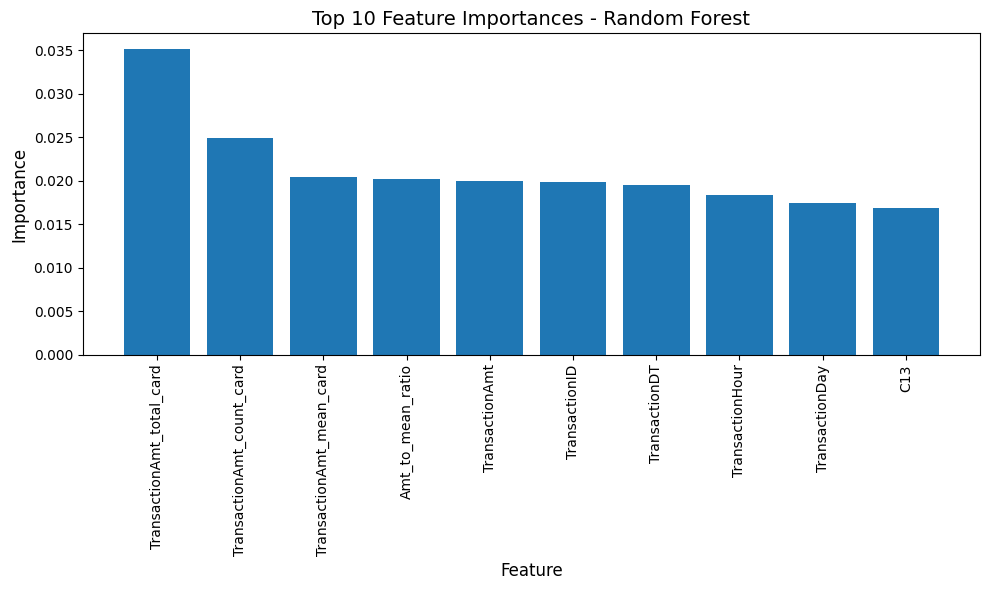

In [ ]:
# Feature Importances from Random Forest
# Get feature importances from Random Forest
importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances - Random Forest', fontsize=14)
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), X_train_cleaned.columns[indices[:10]], rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Accuracy
accuracy_rf = accuracy_score(y_test_cleaned, y_pred_rf)
accuracy_if = accuracy_score(y_test_cleaned, y_pred_if_binary)

# Precision
precision_rf = precision_score(y_test_cleaned, y_pred_rf, average='binary')
precision_if = precision_score(y_test_cleaned, y_pred_if_binary, average='binary')

# Recall
recall_rf = recall_score(y_test_cleaned, y_pred_rf, average='binary')
recall_if = recall_score(y_test_cleaned, y_pred_if_binary, average='binary')

#  F1 Score
f1_rf = f1_score(y_test_cleaned, y_pred_rf, average='binary')
f1_if = f1_score(y_test_cleaned, y_pred_if_binary, average='binary')

# ROC AUC Score
roc_auc_rf = roc_auc_score(y_test_cleaned, y_pred_rf)
roc_auc_if = roc_auc_score(y_test_cleaned, y_pred_if_binary)

# Confusion Matrices
conf_matrix_rf = confusion_matrix(y_test_cleaned, y_pred_rf)
conf_matrix_if = confusion_matrix(y_test_cleaned, y_pred_if_binary)

# Display Classification Reports
print("Random Forest Classification Report:\n", classification_report(y_test_cleaned, y_pred_rf))
print("Isolation Forest Classification Report:\n", classification_report(y_test_cleaned, y_pred_if_binary))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      2903
           1       0.87      0.80      0.83      2813

    accuracy                           0.84      5716
   macro avg       0.84      0.84      0.84      5716
weighted avg       0.84      0.84      0.84      5716

Isolation Forest Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.99      0.68      2903
           1       0.86      0.06      0.11      2813

    accuracy                           0.53      5716
   macro avg       0.69      0.53      0.40      5716
weighted avg       0.69      0.53      0.40      5716



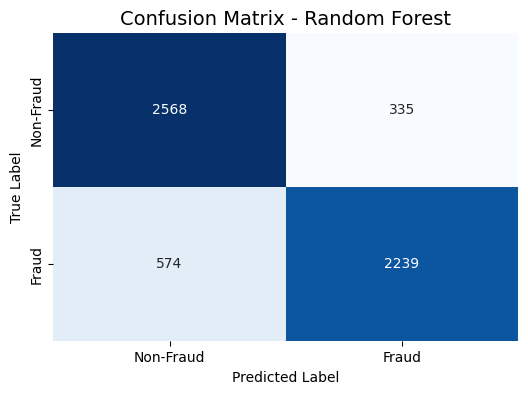

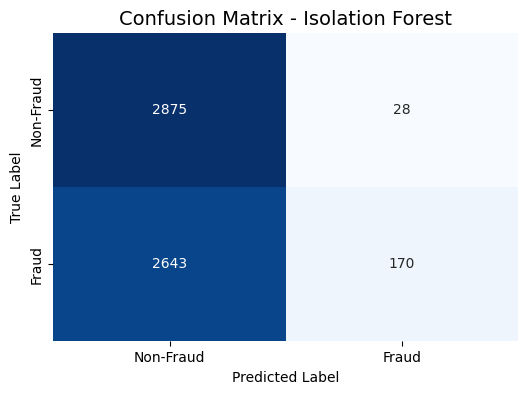

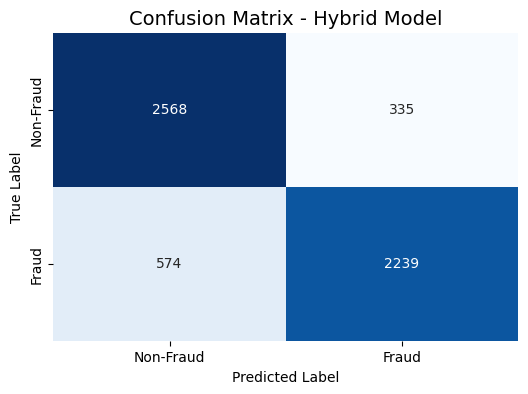

In [ ]:
# Plot Confusion Matrices
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(conf_matrix_rf, 'Random Forest')
plot_confusion_matrix(conf_matrix_if, 'Isolation Forest')
plot_confusion_matrix(conf_matrix_hybrid, 'Hybrid Model')

##Hyperparameter Tuning

In [ ]:
# Check if best_rf_model is already trained
if 'best_rf_model' not in globals():
    print("Random Forest model not found. Defining and training the model...")

    # Define the best hyperparameters (manually set as you have already tuned them)
    best_rf_model = RandomForestClassifier(
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=100,
        random_state=42
    )

    # Ensure features are aligned between train and test data
    def align_features(train, test):
        test_aligned = test.reindex(columns=train.columns, fill_value=0)
        return train, test_aligned

    # Align the training and testing data
    X_train_aligned, X_test_aligned = align_features(X_train_cleaned, X_test_cleaned)

    # Train the model
    best_rf_model.fit(X_train_aligned, y_train_cleaned)
    print("Random Forest model successfully trained.")
else:
    print("Random Forest model already exists. Skipping training.")

# Make predictions on the aligned test data using the trained best Random Forest model
y_pred_rf_best = best_rf_model.predict(X_test_aligned)
y_prob_rf_best = best_rf_model.predict_proba(X_test_aligned)[:, 1]

# Evaluate the final best Random Forest model
accuracy_rf_best = accuracy_score(y_test_cleaned, y_pred_rf_best)
roc_auc_rf_best = roc_auc_score(y_test_cleaned, y_prob_rf_best)

print(f"Final Accuracy (Best Random Forest): {accuracy_rf_best:.4f}")
print(f"Final ROC AUC (Best Random Forest): {roc_auc_rf_best:.4f}")

Random Forest model not found. Defining and training the model...
Random Forest model successfully trained.
Final Accuracy (Best Random Forest): 0.8410
Final ROC AUC (Best Random Forest): 0.9233


In [ ]:
# Manually set the best hyperparameters for Isolation Forest
best_if_model = IsolationForest(
    n_estimators=50,       # Best n_estimators from tuning
    max_samples=0.8,       # Best max_samples from tuning
    contamination=0.05,    # Best contamination from tuning
    max_features=0.8,      # Best max_features from tuning
    random_state=42
)

# Train the best Isolation Forest model on the aligned training data
best_if_model.fit(X_train_cleaned)

# Make final predictions on the cleaned test data using the best Isolation Forest model
y_pred_if_best = best_if_model.predict(X_test_cleaned)

# Convert predictions (-1 is considered an anomaly/fraud, 1 is normal)
y_pred_if_binary_best = [1 if pred == -1 else 0 for pred in y_pred_if_best]

# Evaluate the final best Isolation Forest model
accuracy_if_best = accuracy_score(y_test_cleaned, y_pred_if_binary_best)
roc_auc_if_best = roc_auc_score(y_test_cleaned, y_pred_if_binary_best)

# Output evaluation metrics
print(f"Final Accuracy (Best Isolation Forest): {accuracy_if_best:.4f}")
print(f"Final ROC AUC (Best Isolation Forest): {roc_auc_if_best:.4f}")

Final Accuracy (Best Isolation Forest): 0.5376
Final ROC AUC (Best Isolation Forest): 0.5307


In [ ]:
# Use the best RandomForest model without retraining
y_pred_rf_best = best_rf_model.predict(X_test_cleaned)

# Use the best Isolation Forest model without retraining
y_pred_if_best = best_if_model.predict(X_test_cleaned)
y_pred_if_binary_best = [1 if pred == -1 else 0 for pred in y_pred_if_best]

# Stack the best model predictions
stacked_predictions_best = np.column_stack((y_pred_rf_best, y_pred_if_binary_best))

# Check if the Logistic Regression hybrid model has already been trained
if 'hybrid_model_best' not in globals():
    # Train the Logistic Regression hybrid model on the best predictions
    hybrid_model_best = LogisticRegression(random_state=42)
    hybrid_model_best.fit(stacked_predictions_best, y_test_cleaned)
else:
    print("Logistic Regression hybrid model already trained, skipping training...")

# Make predictions using the hybrid model
final_pred_best = hybrid_model_best.predict(stacked_predictions_best)

# Evaluate the hybrid model performance
accuracy_hybrid_best = accuracy_score(y_test_cleaned, final_pred_best)
roc_auc_hybrid_best = roc_auc_score(y_test_cleaned, final_pred_best)

# Print the evaluation metrics for the hybrid model
print("Best Hybrid Model Accuracy: ", accuracy_hybrid_best)
print("Best Hybrid Model ROC AUC Score: ", roc_auc_hybrid_best)

Best Hybrid Model Accuracy:  0.8409727081875438
Best Hybrid Model ROC AUC Score:  0.8402747614264219


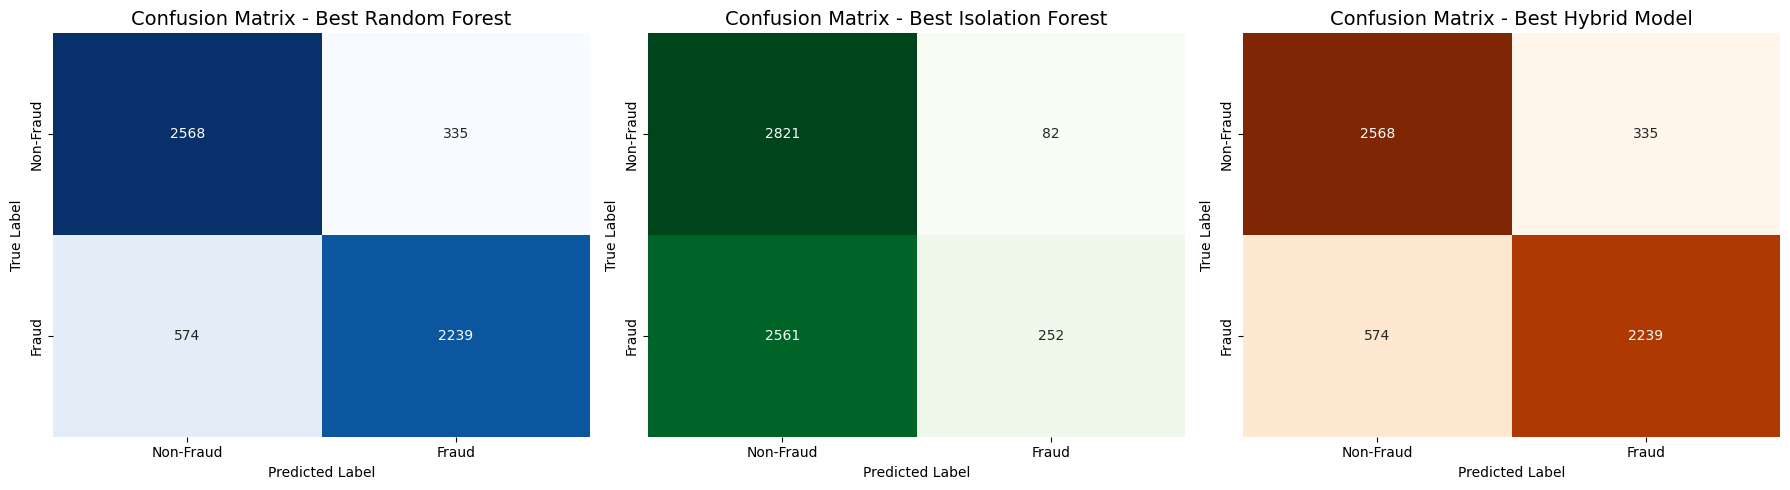

In [ ]:
# Confusion matrices for each model
conf_matrix_rf_best = confusion_matrix(y_test_cleaned, y_pred_rf_best)
conf_matrix_if_best = confusion_matrix(y_test_cleaned, y_pred_if_binary_best)
conf_matrix_hybrid_best = confusion_matrix(y_test_cleaned, final_pred_best)

# Set up the figure
plt.figure(figsize=(18, 5))

# Random Forest
plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_rf_best, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Best Random Forest', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Isolation Forest
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_if_best, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Best Isolation Forest', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Hybrid Model
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_hybrid_best, annot=True, fmt='d', cmap='Oranges', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Best Hybrid Model', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

plt.tight_layout()
plt.show()

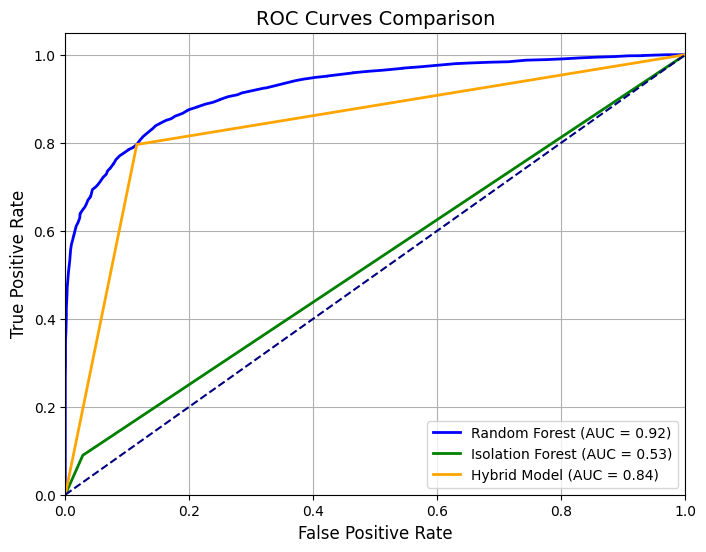

In [ ]:
# Compute ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test_cleaned, y_prob_rf_best)
fpr_if, tpr_if, _ = roc_curve(y_test_cleaned, y_pred_if_binary_best)
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test_cleaned, final_pred_best)

# Compute AUC
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_if = auc(fpr_if, tpr_if)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_if, tpr_if, color='green', lw=2, label=f'Isolation Forest (AUC = {roc_auc_if:.2f})')
plt.plot(fpr_hybrid, tpr_hybrid, color='orange', lw=2, label=f'Hybrid Model (AUC = {roc_auc_hybrid:.2f})')

# Random line
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##XGBoost Classifier Model Evaluation

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2903
           1       0.89      0.86      0.88      2813

    accuracy                           0.88      5716
   macro avg       0.88      0.88      0.88      5716
weighted avg       0.88      0.88      0.88      5716

Accuracy (XGBoost): 0.8809
ROC AUC Score (XGBoost): 0.9527

Confusion Matrix (XGBoost):
 [[2619  284]
 [ 397 2416]]


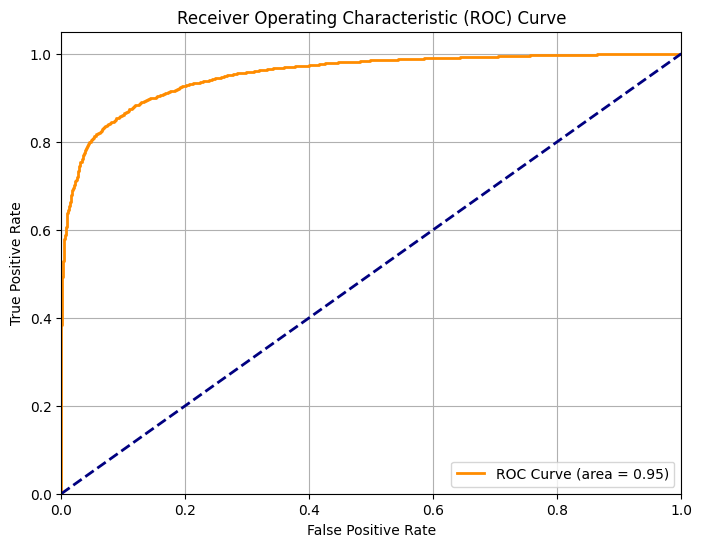

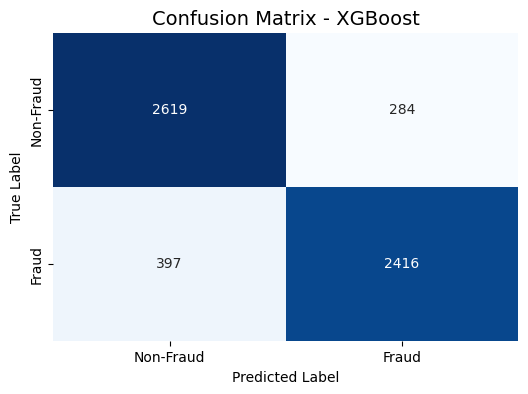

In [ ]:
# Initialize the XGBoost classifier
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model on the cleaned training data
xgb_model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_cleaned)
y_pred_xgb_proba = xgb_model.predict_proba(X_test_cleaned)[:, 1]  # Probabilities for ROC AUC

# Evaluate the XGBoost model performance

# Classification report
print("XGBoost Classification Report:\n", classification_report(y_test_cleaned, y_pred_xgb))

# Accuracy score
accuracy_xgb = accuracy_score(y_test_cleaned, y_pred_xgb)
print(f"Accuracy (XGBoost): {accuracy_xgb:.4f}")

# ROC AUC score
roc_auc_xgb = roc_auc_score(y_test_cleaned, y_pred_xgb_proba)
print(f"ROC AUC Score (XGBoost): {roc_auc_xgb:.4f}")

# Confusion matrix
conf_matrix_xgb = confusion_matrix(y_test_cleaned, y_pred_xgb)
print("\nConfusion Matrix (XGBoost):\n", conf_matrix_xgb)

# Plot ROC Curve
plot_roc_curve(y_test_cleaned, y_pred_xgb_proba, roc_auc_xgb)

# Plot confusion matrix
plot_confusion_matrix(conf_matrix_xgb, 'XGBoost')

##LightGBM Classifier Model Evaluation

[LightGBM] [Info] Number of positive: 11253, number of negative: 11609
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16869
[LightGBM] [Info] Number of data points in the train set: 22862, number of used features: 463
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492214 -> initscore=-0.031146
[LightGBM] [Info] Start training from score -0.031146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

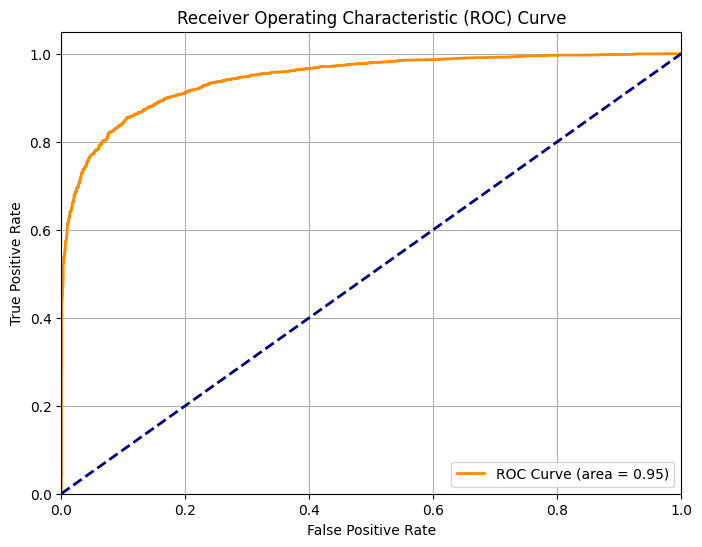

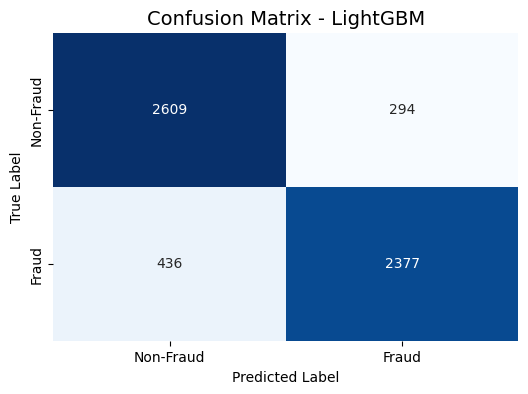

In [ ]:
# Importing the LightGBM library
import lightgbm as lgb

# Initialize the LightGBM classifier
lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42)

# Train the model on the cleaned training data
lgb_model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the test data
y_pred_lgb = lgb_model.predict(X_test_cleaned)
y_pred_lgb_proba = lgb_model.predict_proba(X_test_cleaned)[:, 1]  # Probabilities for ROC AUC

# Evaluate the LightGBM model performance

# Classification report
print("LightGBM Classification Report:\n", classification_report(y_test_cleaned, y_pred_lgb))

# Accuracy score
accuracy_lgb = accuracy_score(y_test_cleaned, y_pred_lgb)
print(f"Accuracy (LightGBM): {accuracy_lgb:.4f}")

# ROC AUC score
roc_auc_lgb = roc_auc_score(y_test_cleaned, y_pred_lgb_proba)
print(f"ROC AUC Score (LightGBM): {roc_auc_lgb:.4f}")

# Confusion matrix
conf_matrix_lgb = confusion_matrix(y_test_cleaned, y_pred_lgb)
print("\nConfusion Matrix (LightGBM):\n", conf_matrix_lgb)

# Plot ROC Curve
plot_roc_curve(y_test_cleaned, y_pred_lgb_proba, roc_auc_lgb)

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix_lgb, 'LightGBM')

##CatBoost Classifier Model Evaluation

CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      2903
           1       0.88      0.83      0.86      2813

    accuracy                           0.86      5716
   macro avg       0.86      0.86      0.86      5716
weighted avg       0.86      0.86      0.86      5716

Accuracy (CatBoost): 0.8630
ROC AUC Score (CatBoost): 0.9385

Confusion Matrix (CatBoost):
 [[2597  306]
 [ 477 2336]]


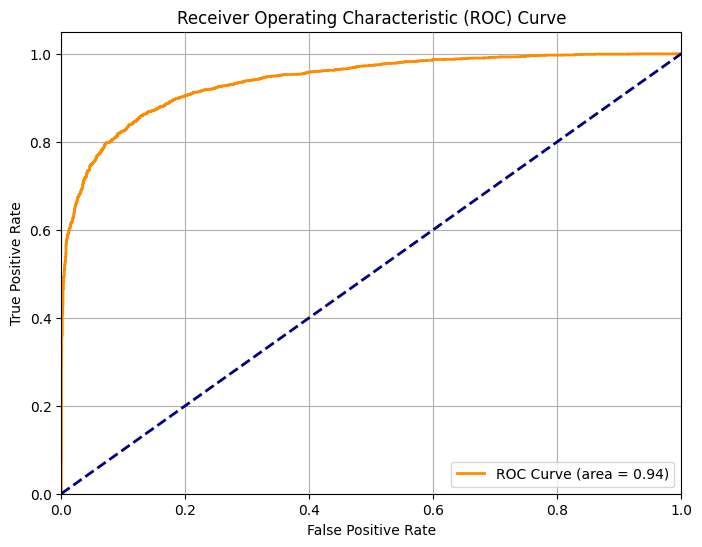

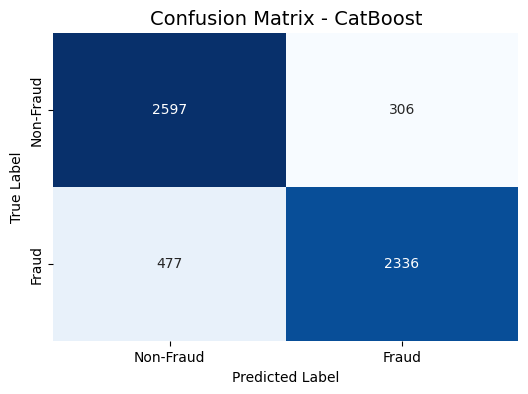

In [ ]:
# Initialize the CatBoost classifier
catboost_model = CatBoostClassifier(n_estimators=500, learning_rate=0.05, depth=7, random_state=42, verbose=0)

# Train the model on the cleaned training data
catboost_model.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the test data
y_pred_catboost = catboost_model.predict(X_test_cleaned)
y_pred_catboost_proba = catboost_model.predict_proba(X_test_cleaned)[:, 1]

# Evaluate the CatBoost model performance

# Classification report
print("CatBoost Classification Report:\n", classification_report(y_test_cleaned, y_pred_catboost))

# Accuracy score
accuracy_catboost = accuracy_score(y_test_cleaned, y_pred_catboost)
print(f"Accuracy (CatBoost): {accuracy_catboost:.4f}")

# ROC AUC score
roc_auc_catboost = roc_auc_score(y_test_cleaned, y_pred_catboost_proba)
print(f"ROC AUC Score (CatBoost): {roc_auc_catboost:.4f}")

# Confusion matrix
conf_matrix_catboost = confusion_matrix(y_test_cleaned, y_pred_catboost)
print("\nConfusion Matrix (CatBoost):\n", conf_matrix_catboost)

# Plot ROC Curve
plot_roc_curve(y_test_cleaned, y_pred_catboost_proba, roc_auc_catboost)

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix_catboost, 'CatBoost')

In [ ]:
# Collect accuracy and ROC AUC scores for each model (including Isolation Forest)
model_names = ['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost', 'Isolation Forest']
accuracies = [accuracy_rf, accuracy_xgb, accuracy_lgb, accuracy_catboost, accuracy_if]
roc_aucs = [roc_auc_rf, roc_auc_xgb, roc_auc_lgb, roc_auc_catboost, roc_auc_if]

# Collect the ROC curve data (False Positive Rate and True Positive Rate) for each model (including Isolation Forest)
roc_data = {
    'Random Forest': roc_curve(y_test_cleaned, y_pred_rf),
    'XGBoost': roc_curve(y_test_cleaned, y_pred_xgb_proba),
    'LightGBM': roc_curve(y_test_cleaned, y_pred_lgb_proba),
    'CatBoost': roc_curve(y_test_cleaned, y_pred_catboost_proba),
    'Isolation Forest': roc_curve(y_test_cleaned, y_pred_if_binary)  # Binary predictions for Isolation Forest
}

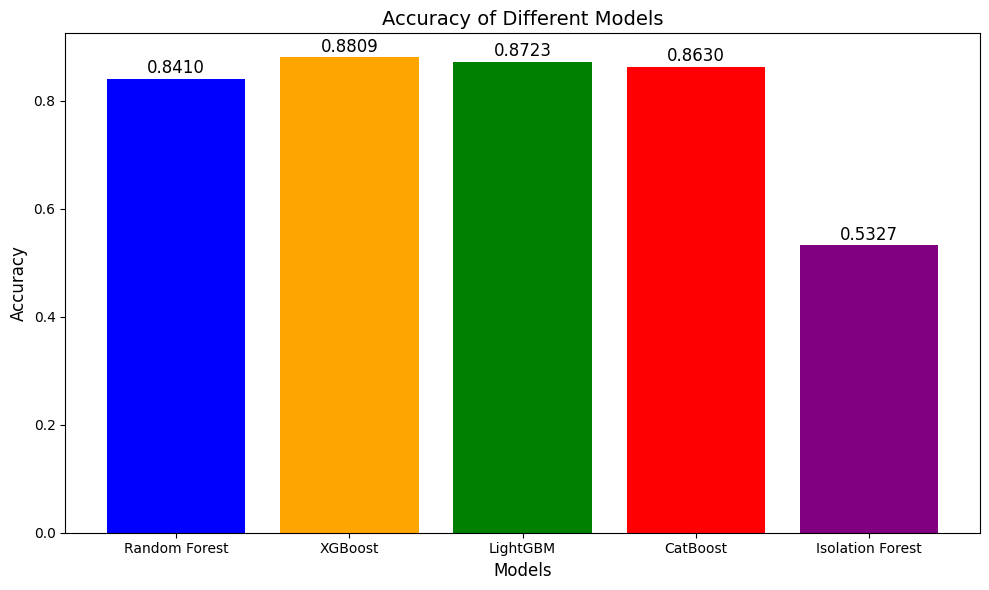

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the accuracy of all models (including Isolation Forest) in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Accuracy of Different Models', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Add accuracy values on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()

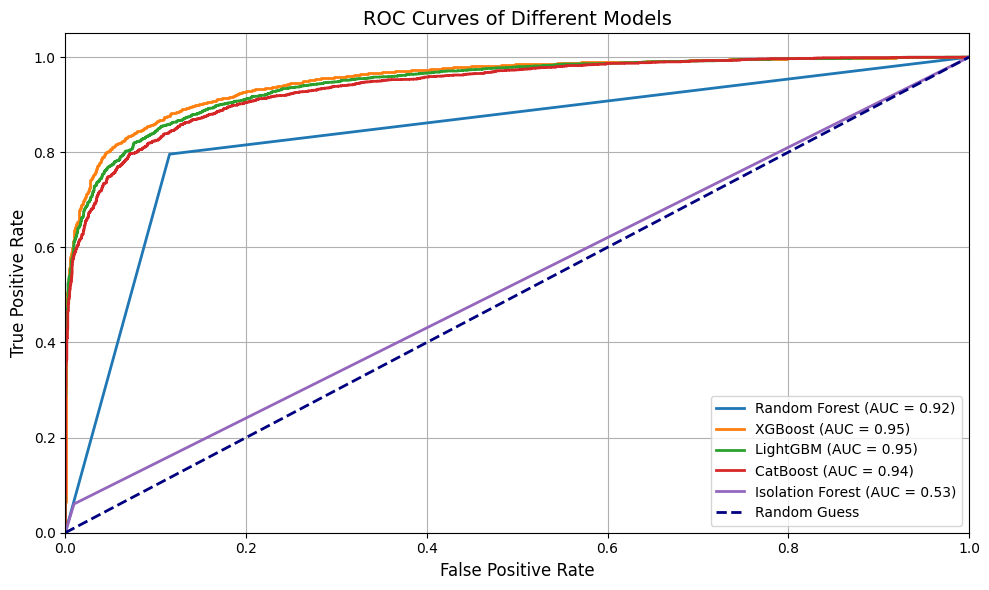

In [ ]:
# Plot ROC Curves of all models in one graph (including Isolation Forest)
plt.figure(figsize=(10, 6))

# Loop through each model and plot its ROC curve
for model_name, (fpr, tpr, _) in roc_data.items():
    roc_auc = roc_aucs[model_names.index(model_name)]
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Add the diagonal line for random performance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves of Different Models', fontsize=14)
plt.legend(loc="lower right", fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.show()

Optimized Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85      2903
           1       0.87      0.80      0.83      2813

    accuracy                           0.84      5716
   macro avg       0.85      0.84      0.84      5716
weighted avg       0.85      0.84      0.84      5716

Optimized Accuracy (Random Forest): 0.8432
Optimized ROC AUC Score (Random Forest): 0.9242

Optimized Confusion Matrix (Random Forest):
 [[2570  333]
 [ 563 2250]]


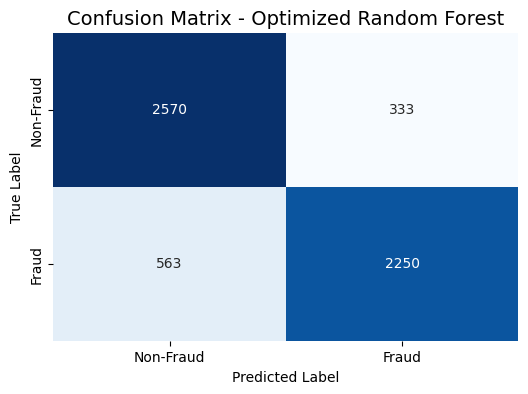

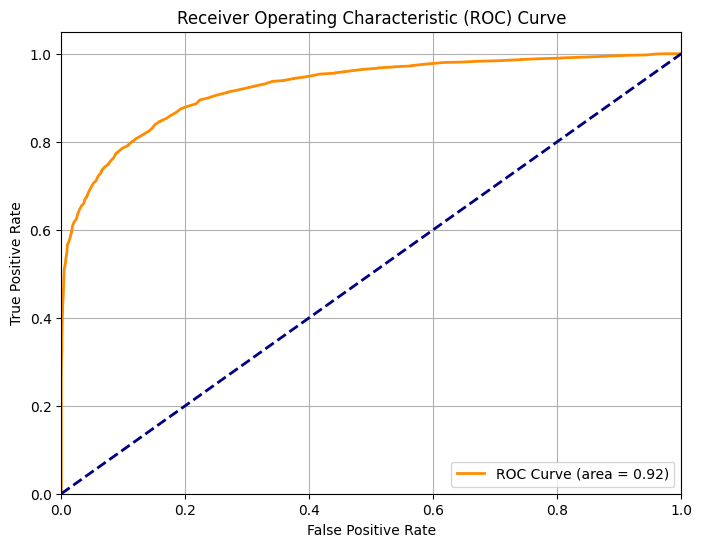

In [ ]:
# Best hyperparameters you provided
best_params = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

# Initialize the Random Forest with the best hyperparameters
rf_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight='balanced',  # Handling class imbalance
    random_state=42
)

# Train the optimized Random Forest model
rf_optimized.fit(X_train_cleaned, y_train_cleaned)

# Make predictions on the test set
y_pred_rf_optimized = rf_optimized.predict(X_test_cleaned)
y_pred_rf_optimized_proba = rf_optimized.predict_proba(X_test_cleaned)[:, 1]  # Probabilities for ROC AUC

# Evaluate the optimized Random Forest model

# Classification report
print("Optimized Random Forest Classification Report:\n", classification_report(y_test_cleaned, y_pred_rf_optimized))

# Accuracy score
accuracy_rf_optimized = accuracy_score(y_test_cleaned, y_pred_rf_optimized)
print(f"Optimized Accuracy (Random Forest): {accuracy_rf_optimized:.4f}")

# ROC AUC score
roc_auc_rf_optimized = roc_auc_score(y_test_cleaned, y_pred_rf_optimized_proba)
print(f"Optimized ROC AUC Score (Random Forest): {roc_auc_rf_optimized:.4f}")

# Confusion matrix
conf_matrix_rf_optimized = confusion_matrix(y_test_cleaned, y_pred_rf_optimized)
print("\nOptimized Confusion Matrix (Random Forest):\n", conf_matrix_rf_optimized)

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix_rf_optimized, 'Optimized Random Forest')

# Plot ROC Curve for the optimized Random Forest
plot_roc_curve(y_test_cleaned, y_pred_rf_optimized_proba, roc_auc_rf_optimized)

In [ ]:
# Initialize and train Random Forest model
rf_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    class_weight='balanced',  # Handling class imbalance
    random_state=42
)
rf_optimized.fit(X_train_cleaned, y_train_cleaned)

# Initialize and train XGBoost model
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=7, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train_cleaned, y_train_cleaned)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

##Hybrid Model (RF+XGB)

In [ ]:
# Get the predictions from both models on the test set
y_pred_rf_proba = rf_optimized.predict_proba(X_test_cleaned)[:, 1]  # Probabilities from Random Forest
y_pred_xgb_proba = xgb_model.predict_proba(X_test_cleaned)[:, 1]  # Probabilities from XGBoost

# Stack the predictions into a new feature set for the meta-classifier
stacked_predictions = np.column_stack((y_pred_rf_proba, y_pred_xgb_proba))

In [ ]:
# Initialize Logistic Regression as the meta-classifier
meta_classifier = LogisticRegression(random_state=42)

# Train the meta-classifier on the stacked predictions (from RF and XGBoost/LightGBM)
meta_classifier.fit(stacked_predictions, y_test_cleaned)  # y_test_cleaned is used here since we're training it on predictions for the test set

# Make predictions with the meta-classifier
final_pred = meta_classifier.predict(stacked_predictions)
final_pred_proba = meta_classifier.predict_proba(stacked_predictions)[:, 1]  # Probabilities for ROC AUC

Hybrid Model Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      2903
           1       0.89      0.86      0.88      2813

    accuracy                           0.88      5716
   macro avg       0.88      0.88      0.88      5716
weighted avg       0.88      0.88      0.88      5716

Accuracy (Hybrid Model): 0.8809
ROC AUC Score (Hybrid Model): 0.9525

Confusion Matrix (Hybrid Model):
 [[2611  292]
 [ 389 2424]]


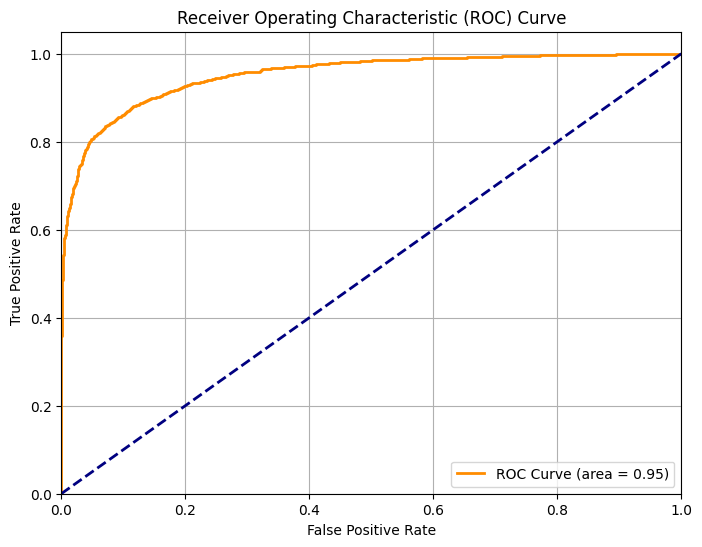

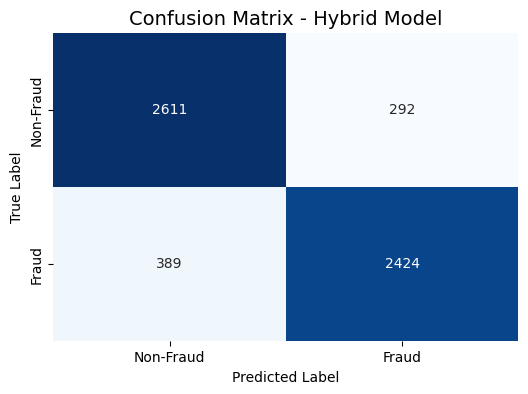

In [ ]:
# Classification report for the hybrid model
print("Hybrid Model Classification Report:\n", classification_report(y_test_cleaned, final_pred))

# Accuracy score
accuracy_hybrid = accuracy_score(y_test_cleaned, final_pred)
print(f"Accuracy (Hybrid Model): {accuracy_hybrid:.4f}")

# ROC AUC score
roc_auc_hybrid = roc_auc_score(y_test_cleaned, final_pred_proba)
print(f"ROC AUC Score (Hybrid Model): {roc_auc_hybrid:.4f}")

# Confusion matrix
conf_matrix_hybrid = confusion_matrix(y_test_cleaned, final_pred)
print("\nConfusion Matrix (Hybrid Model):\n", conf_matrix_hybrid)

# Plot ROC Curve for the hybrid model
plot_roc_curve(y_test_cleaned, final_pred_proba, roc_auc_hybrid)

# Plot Confusion Matrix
plot_confusion_matrix(conf_matrix_hybrid, 'Hybrid Model')

Hybrid Model with XGBoost Meta-Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      2903
           1       0.90      0.86      0.88      2813

    accuracy                           0.89      5716
   macro avg       0.89      0.89      0.89      5716
weighted avg       0.89      0.89      0.89      5716

Accuracy (Hybrid Model with XGBoost): 0.8858
ROC AUC Score (Hybrid Model with XGBoost): 0.9536

Confusion Matrix (Hybrid Model with XGBoost):
 [[2642  261]
 [ 392 2421]]


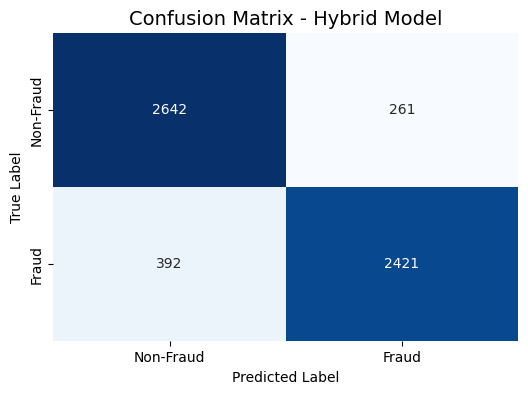

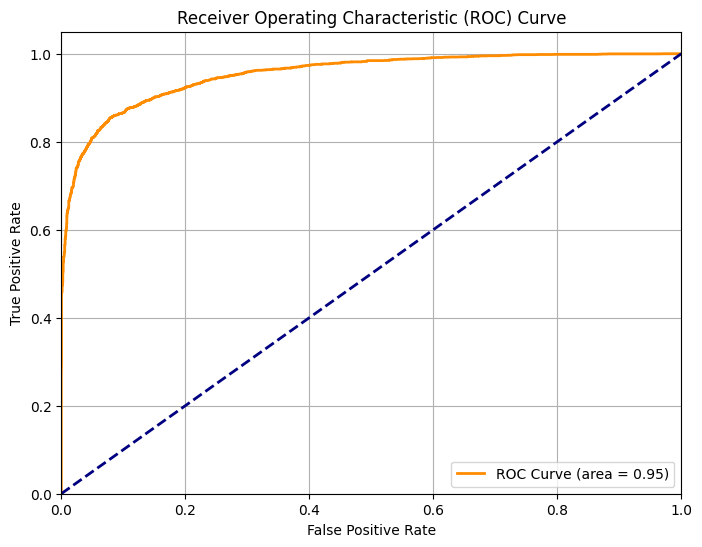

In [ ]:
# Stack predictions from Random Forest and LightGBM or XGBoost
y_pred_rf_proba = rf_optimized.predict_proba(X_test_cleaned)[:, 1]  # Predictions from Random Forest
y_pred_xgb_proba = xgb_model.predict_proba(X_test_cleaned)[:, 1]  # Predictions from XGBoost (or use LightGBM)

# Combine predictions into a new feature set for the meta-model
stacked_predictions = np.column_stack((y_pred_rf_proba, y_pred_xgb_proba))

# Use XGBoost as the meta-classifier
meta_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)

# Train the meta-classifier on the stacked predictions
meta_model.fit(stacked_predictions, y_test_cleaned)

# Make final predictions with the hybrid model
final_pred = meta_model.predict(stacked_predictions)
final_pred_proba = meta_model.predict_proba(stacked_predictions)[:, 1]

# Evaluate the hybrid model
print("Hybrid Model with XGBoost Meta-Classifier Classification Report:\n", classification_report(y_test_cleaned, final_pred))
accuracy_hybrid = accuracy_score(y_test_cleaned, final_pred)
print(f"Accuracy (Hybrid Model with XGBoost): {accuracy_hybrid:.4f}")
roc_auc_hybrid = roc_auc_score(y_test_cleaned, final_pred_proba)
print(f"ROC AUC Score (Hybrid Model with XGBoost): {roc_auc_hybrid:.4f}")

# Confusion Matrix
conf_matrix_hybrid = confusion_matrix(y_test_cleaned, final_pred)
print("\nConfusion Matrix (Hybrid Model with XGBoost):\n", conf_matrix_hybrid)
plot_confusion_matrix(conf_matrix_hybrid, 'Hybrid Model')

# Plot ROC Curve for the hybrid model
plot_roc_curve(y_test_cleaned, final_pred_proba, roc_auc_hybrid)

##SHAP Values

In [ ]:
# Check if there are any columns with object or mixed data types
print("Data types in X_train_cleaned:\n", X_train_cleaned.dtypes)
print("Data types in X_test_cleaned:\n", X_test_cleaned.dtypes)

Data types in X_train_cleaned:
 TransactionID               float64
TransactionDT               float64
TransactionAmt              float64
card1                       float64
card2                       float64
                             ...   
V7_-0.375367274217479          bool
C3_39.83360476037616           bool
addr2_-8.152351767947751       bool
V289_7.658508338761047         bool
V16_9.33407331781068           bool
Length: 745, dtype: object
Data types in X_test_cleaned:
 TransactionID               float64
TransactionDT               float64
TransactionAmt              float64
card1                       float64
card2                       float64
                             ...   
V7_-0.375367274217479         int64
C3_39.83360476037616          int64
addr2_-8.152351767947751      int64
V289_7.658508338761047        int64
V16_9.33407331781068          int64
Length: 745, dtype: object


In [ ]:
# Convert bool columns to float64
X_train_cleaned = X_train_cleaned.astype({col: 'float64' for col in X_train_cleaned.select_dtypes(include=['bool']).columns})
X_test_cleaned = X_test_cleaned.astype({col: 'float64' for col in X_test_cleaned.select_dtypes(include=['bool']).columns})

# Check if conversion is successful
print("Data types after conversion (X_train_cleaned):\n", X_train_cleaned.dtypes)
print("Data types after conversion (X_test_cleaned):\n", X_test_cleaned.dtypes)

Data types after conversion (X_train_cleaned):
 TransactionID               float64
TransactionDT               float64
TransactionAmt              float64
card1                       float64
card2                       float64
                             ...   
V7_-0.375367274217479       float64
C3_39.83360476037616        float64
addr2_-8.152351767947751    float64
V289_7.658508338761047      float64
V16_9.33407331781068        float64
Length: 745, dtype: object
Data types after conversion (X_test_cleaned):
 TransactionID               float64
TransactionDT               float64
TransactionAmt              float64
card1                       float64
card2                       float64
                             ...   
V7_-0.375367274217479         int64
C3_39.83360476037616          int64
addr2_-8.152351767947751      int64
V289_7.658508338761047        int64
V16_9.33407331781068          int64
Length: 745, dtype: object


In [ ]:
# SHAP explainer for XGBoost
explainer_xgb = shap.Explainer(xgb_model, X_train_cleaned)
shap_values_xgb = explainer_xgb(X_test_cleaned, check_additivity=False)

# SHAP explainer for Random Forest
explainer_rf = shap.Explainer(rf_optimized, X_train_cleaned)
shap_values_rf = explainer_rf(X_test_cleaned, check_additivity=False)

100%|===================| 11428/11432 [35:19<00:00]       

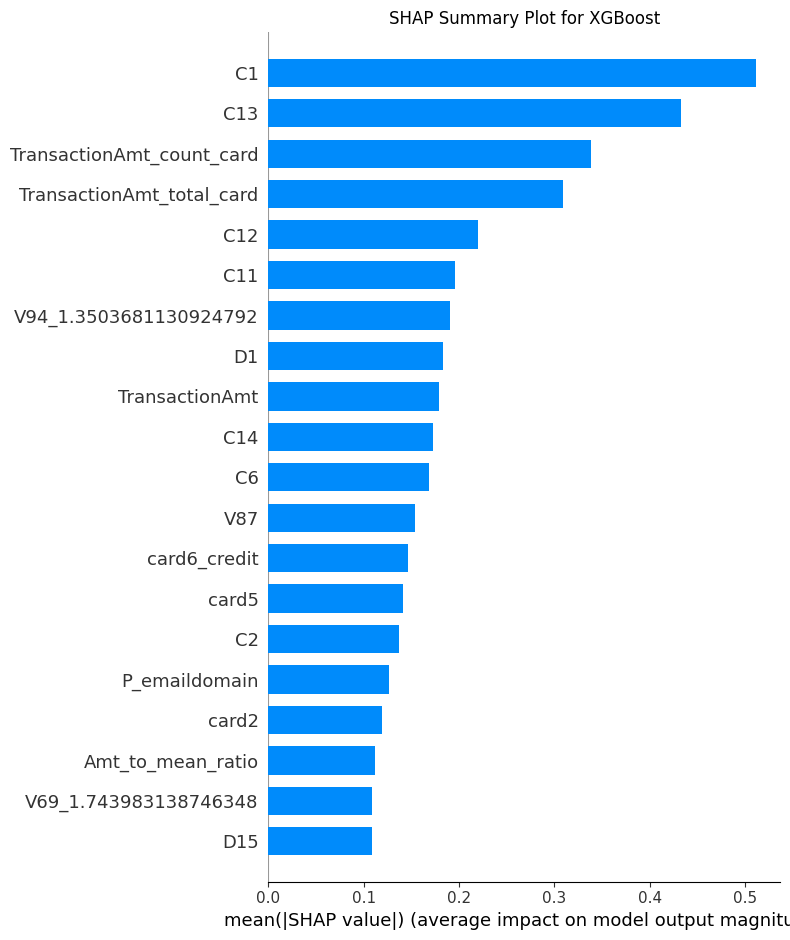

In [ ]:
# SHAP Summary Plot for XGBoost
plt.title("SHAP Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test_cleaned, plot_type="bar")
plt.show()

In [ ]:
# Check the shape of SHAP values for Random Forest
print("Shape of shap_values_rf:", shap_values_rf.values.shape)

# Handle binary classification case
if len(shap_values_rf.values.shape) > 2:
    shap_values_rf_class_1 = shap_values_rf[..., 1]
else:
    shap_values_rf_class_1 = shap_values_rf.values


Shape of shap_values_rf: (5716, 745, 2)


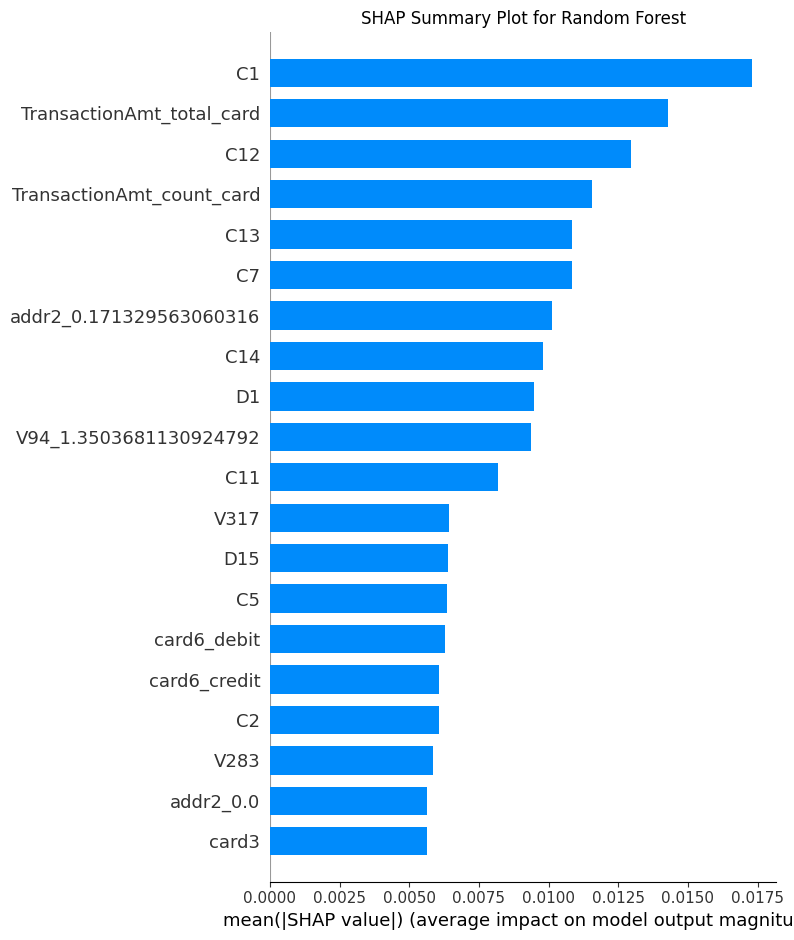

In [ ]:
# Extract SHAP values for class 1 (fraud) in Random Forest
shap_values_rf_class_1 = shap_values_rf[..., 1]

# SHAP Summary Plot for Random Forest (Class 1 - Fraud)
plt.title("SHAP Summary Plot for Random Forest")
shap.summary_plot(shap_values_rf_class_1, X_test_cleaned, plot_type="bar")
plt.show()

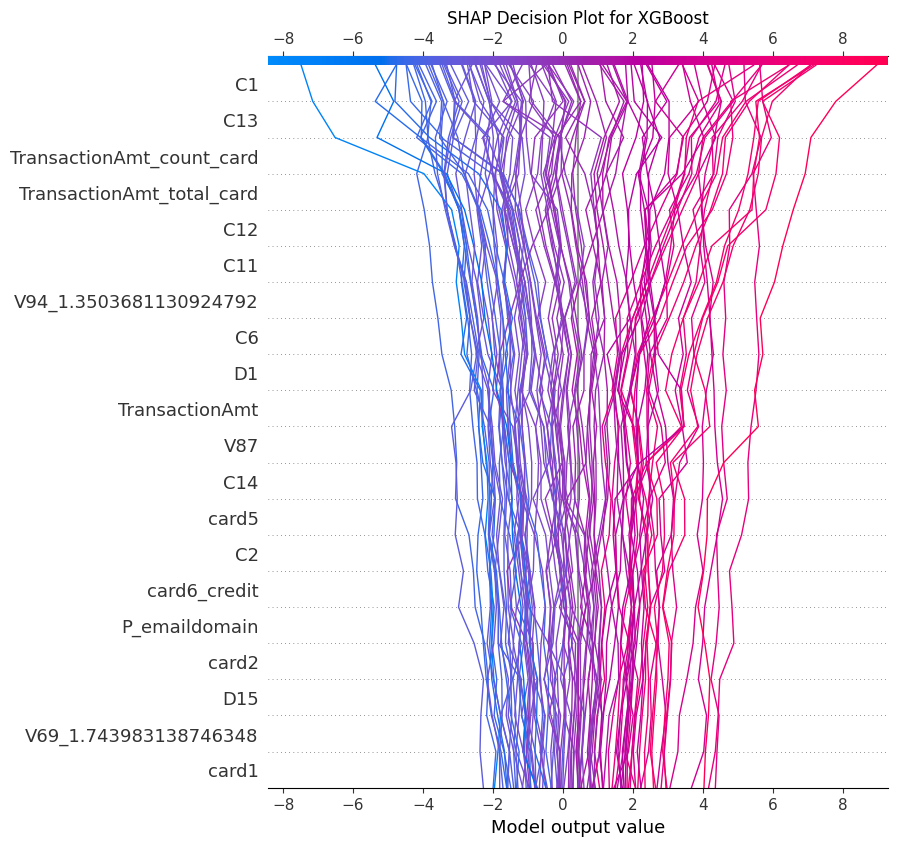

In [ ]:
# SHAP Decision Plot for XGBoost
feature_names = X_test_cleaned.columns.tolist()  # Ensure feature names are passed as a list
plt.title("SHAP Decision Plot for XGBoost")
shap.decision_plot(explainer_xgb.expected_value, shap_values_xgb.values[:100], feature_names=feature_names)
plt.show()

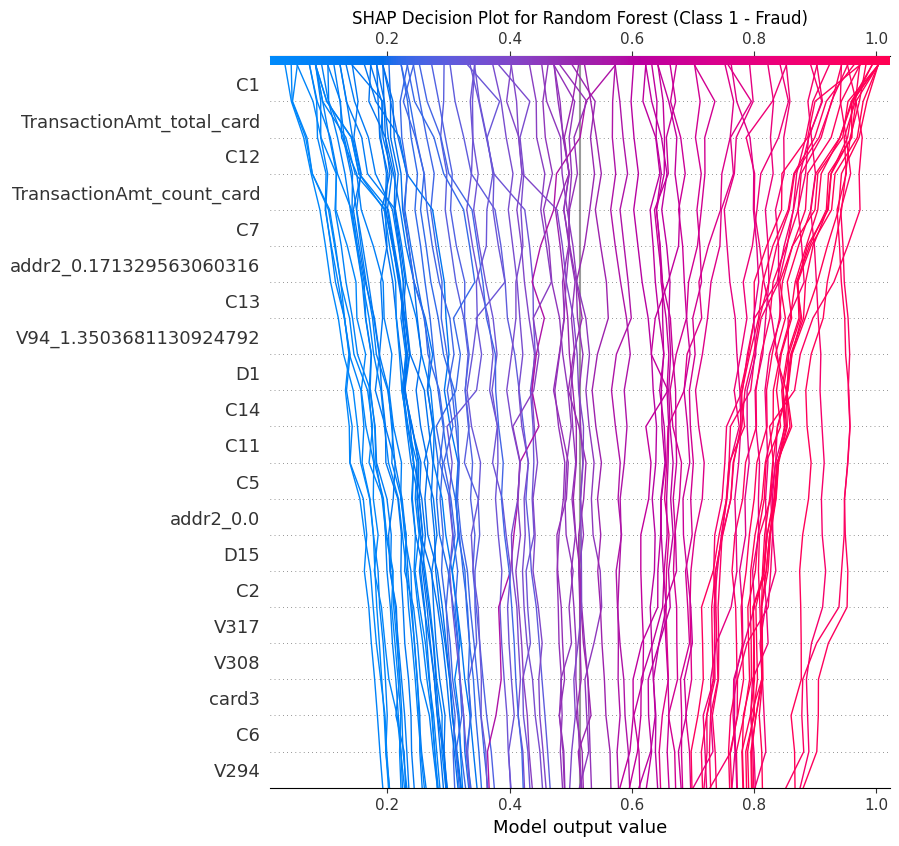

In [ ]:
# Extract SHAP values for class 1 (fraud) for the decision plot (subset of 100 rows)
shap_values_rf_class_1_sample = shap_values_rf_class_1[:100]

# Extract the corresponding test samples
X_test_sample = X_test_cleaned.iloc[:100]

# Convert feature names to a list
feature_names = X_test_cleaned.columns.tolist()

# Extract the raw SHAP values as numpy arrays for the decision plot
shap_values_rf_class_1_sample_values = shap_values_rf_class_1_sample.values if hasattr(shap_values_rf_class_1_sample, 'values') else shap_values_rf_class_1_sample

# SHAP Decision Plot for Random Forest (Class 1 - Fraud)
plt.title("SHAP Decision Plot for Random Forest (Class 1 - Fraud)")
shap.decision_plot(explainer_rf.expected_value[1], shap_values_rf_class_1_sample_values, features=X_test_sample, feature_names=feature_names)
plt.show()

In [ ]:
# Ensure SHAP values are correctly extracted for each feature
explainer_xgb = shap.Explainer(xgb_model, X_train_cleaned)
shap_values_xgb = explainer_xgb(X_test_cleaned, check_additivity=False)

# Since the model is binary, use the shap_values directly (2D array)
shap_values_xgb_class_1 = shap_values_xgb.values  # No need to index for class 1 in binary classification

100%|===================| 5693/5716 [03:42<00:00]       

In [ ]:
print("Shape of shap_values_xgb_class_1:", shap_values_xgb_class_1.shape)

Shape of shap_values_xgb_class_1: (5716, 745)


Shape of shap_values_xgb_class_1: (5716, 745)
First few rows of 'TransactionAmt' from X_test_cleaned:
 32011   -0.327733
31492   -0.327733
17113   -0.974154
29159    0.435028
36351    0.441808
Name: TransactionAmt, dtype: float64
Feature 'TransactionAmt' found. Plotting SHAP Dependence Plot.


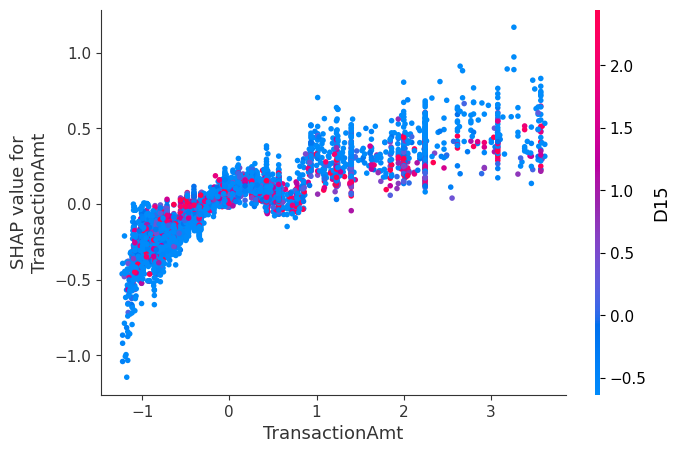

In [ ]:
# Debugging checks
print("Shape of shap_values_xgb_class_1:", shap_values_xgb_class_1.shape)
print("First few rows of 'TransactionAmt' from X_test_cleaned:\n", X_test_cleaned["TransactionAmt"].head())

# SHAP Dependence Plot for 'TransactionAmt' in XGBoost (Class 1 - Fraud)
if 'TransactionAmt' in X_test_cleaned.columns:
    print("Feature 'TransactionAmt' found. Plotting SHAP Dependence Plot.")
    shap.dependence_plot("TransactionAmt", shap_values_xgb_class_1, X_test_cleaned)
    plt.show()
else:
    print("Error: 'TransactionAmt' not found in X_test_cleaned.")

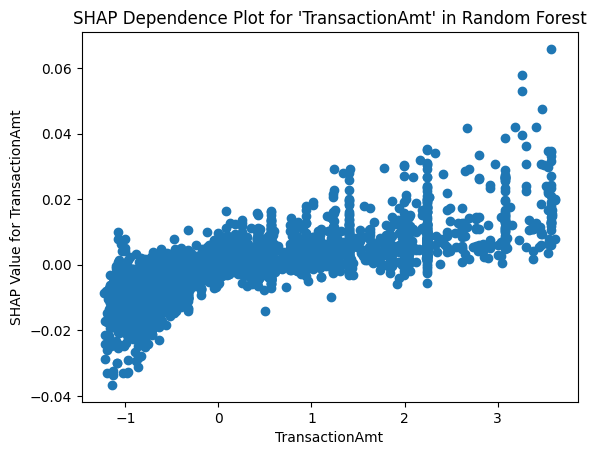

In [ ]:
# Ensure SHAP values for class 1 are extracted properly
transaction_amt_idx = X_test_cleaned.columns.get_loc('TransactionAmt')

# Extract SHAP values for class 1 (fraud) for 'TransactionAmt'
shap_values_rf_class_1_transaction_amt = shap_values_rf_class_1.values[:, transaction_amt_idx]  # Extract the values

# Proceed if sizes match between SHAP values and TransactionAmt feature
transaction_amt_values = X_test_cleaned['TransactionAmt'].values

if shap_values_rf_class_1_transaction_amt.size == transaction_amt_values.size:  # Ensure equal length
    valid_mask = (~np.isnan(transaction_amt_values)) & (~np.isnan(shap_values_rf_class_1_transaction_amt))

    # Filter valid entries
    transaction_amt_values_filtered = transaction_amt_values[valid_mask]
    shap_values_rf_filtered = shap_values_rf_class_1_transaction_amt[valid_mask]

    # Plot the filtered SHAP values for 'TransactionAmt'
    plt.title("SHAP Dependence Plot for 'TransactionAmt' in Random Forest")
    plt.scatter(transaction_amt_values_filtered, shap_values_rf_filtered)
    plt.xlabel('TransactionAmt')
    plt.ylabel('SHAP Value for TransactionAmt')
    plt.show()
else:
    print("Error: SHAP values and 'TransactionAmt' data have different sizes.")

In [ ]:
# Ensure the RandomForest model is trained
if 'random_forest' in globals():
    print("Random Forest model is available. Proceeding with SHAP for Random Forest...")
else:
    raise ValueError("Random Forest model is not defined. Please train the model first.")

Random Forest model is available. Proceeding with SHAP for Random Forest...


In [ ]:
# SHAP Values for Random Forest
#explainer_rf = shap.Explainer(random_forest, X_train_cleaned)
#shap_values_rf = explainer_rf(X_test_cleaned, check_additivity=False)

Shape of shap_values_rf: (5716, 745, 2)


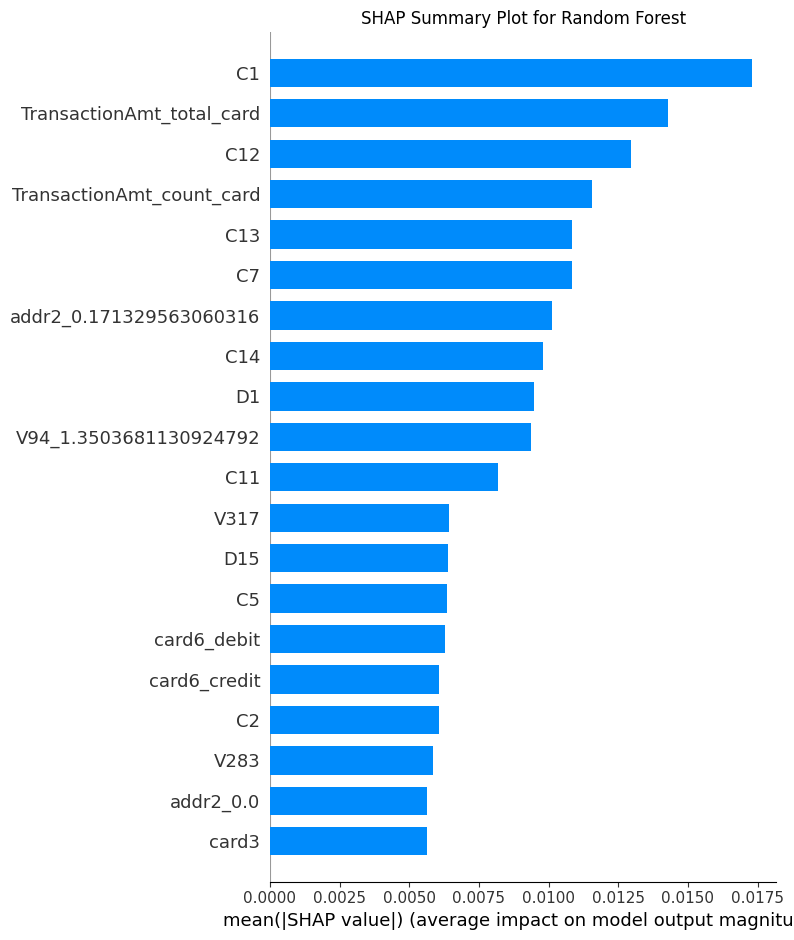

In [ ]:
# Check the shape of SHAP values for Random Forest
print("Shape of shap_values_rf:", shap_values_rf.values.shape)

# Handle binary classification case
if len(shap_values_rf.values.shape) > 2:
    shap_values_rf_class_1 = shap_values_rf[..., 1]
else:
    shap_values_rf_class_1 = shap_values_rf.values

# Extract SHAP values for class 1 (fraud) in Random Forest
shap_values_rf_class_1 = shap_values_rf[..., 1]

# SHAP Summary Plot for Random Forest (Class 1 - Fraud)
plt.title("SHAP Summary Plot for Random Forest")
shap.summary_plot(shap_values_rf_class_1, X_test_cleaned, plot_type="bar")
plt.show()

In [ ]:
# SHAP Values for the Hybrid Model (Logistic Regression)
# Stack the predictions from Random Forest and Isolation Forest for the hybrid model
stacked_predictions = np.column_stack((y_pred_rf, y_pred_if_binary))

In [ ]:
# Ensure the hybrid model (Logistic Regression) is trained
if 'hybrid_model' in globals():
    print("Hybrid model is available. Proceeding with SHAP for the hybrid model...")
else:
    raise ValueError("Hybrid model is not defined. Please train the model first.")

Hybrid model is available. Proceeding with SHAP for the hybrid model...


In [ ]:
# Train SHAP explainer for Logistic Regression hybrid model
explainer_hybrid = shap.Explainer(hybrid_model, stacked_predictions)
shap_values_hybrid = explainer_hybrid(stacked_predictions)

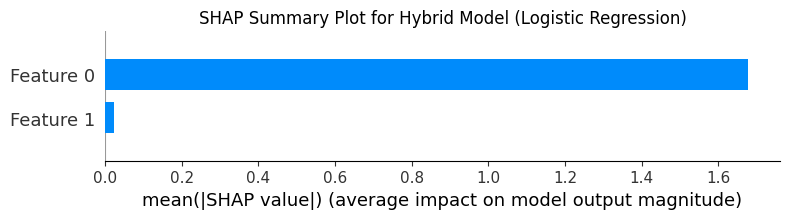

In [ ]:
# SHAP Summary Plot for Hybrid Model (Logistic Regression)
plt.title("SHAP Summary Plot for Hybrid Model (Logistic Regression)")
shap.summary_plot(shap_values_hybrid, stacked_predictions, plot_type="bar")
plt.show()

Plotting SHAP Dependence Plot for 'TransactionAmt' in Random Forest and Hybrid Model...


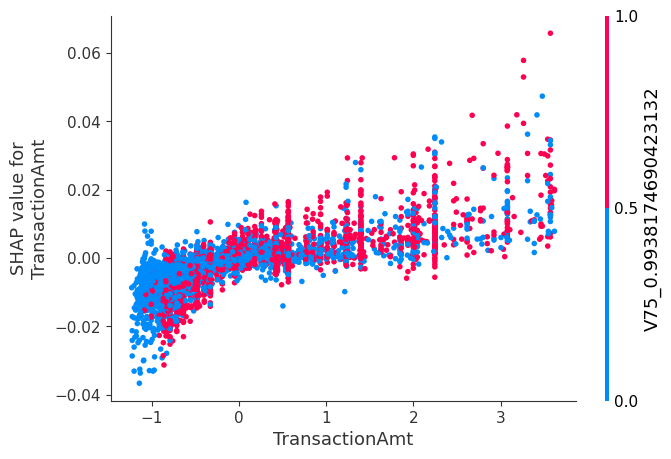

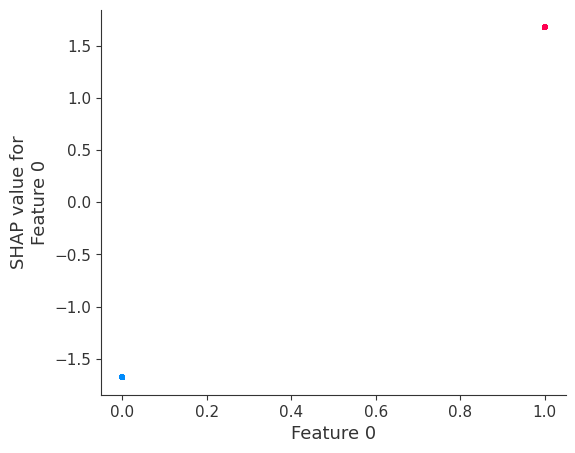

In [ ]:
# SHAP Dependence Plot for Random Forest and Hybrid Model
if 'TransactionAmt' in X_test_cleaned.columns:
    print("Plotting SHAP Dependence Plot for 'TransactionAmt' in Random Forest and Hybrid Model...")

    # Extract SHAP values for class 1 (fraud) for Random Forest
    if shap_values_rf.values.ndim == 3:
        # We are dealing with multi-class (binary) SHAP values, extract class 1 (fraud) values
        shap_values_rf_class_1 = shap_values_rf.values[:, :, 1]  # Extract for class 1
    elif shap_values_rf.values.ndim == 2:
        # If already 2D (binary classifier output), use directly
        shap_values_rf_class_1 = shap_values_rf.values
    else:
        raise ValueError("Unexpected shape for shap_values_rf, expected 2D or 3D array.")

    # Ensure SHAP values and X_test_cleaned are aligned
    if shap_values_rf_class_1.shape[0] != X_test_cleaned.shape[0]:
        raise ValueError("Mismatch between number of SHAP values and rows in X_test_cleaned.")

    # SHAP Dependence Plot for Random Forest (Class 1 - Fraud)
    shap.dependence_plot("TransactionAmt", shap_values_rf_class_1, X_test_cleaned)
    plt.show()

    # SHAP Dependence Plot for Hybrid Model (Logistic Regression)
    shap.dependence_plot(0, shap_values_hybrid.values, stacked_predictions)
    plt.show()
else:
    print("Error: 'TransactionAmt' not found in X_test_cleaned.")

Shape of shap_values_rf: (5716, 745, 2)


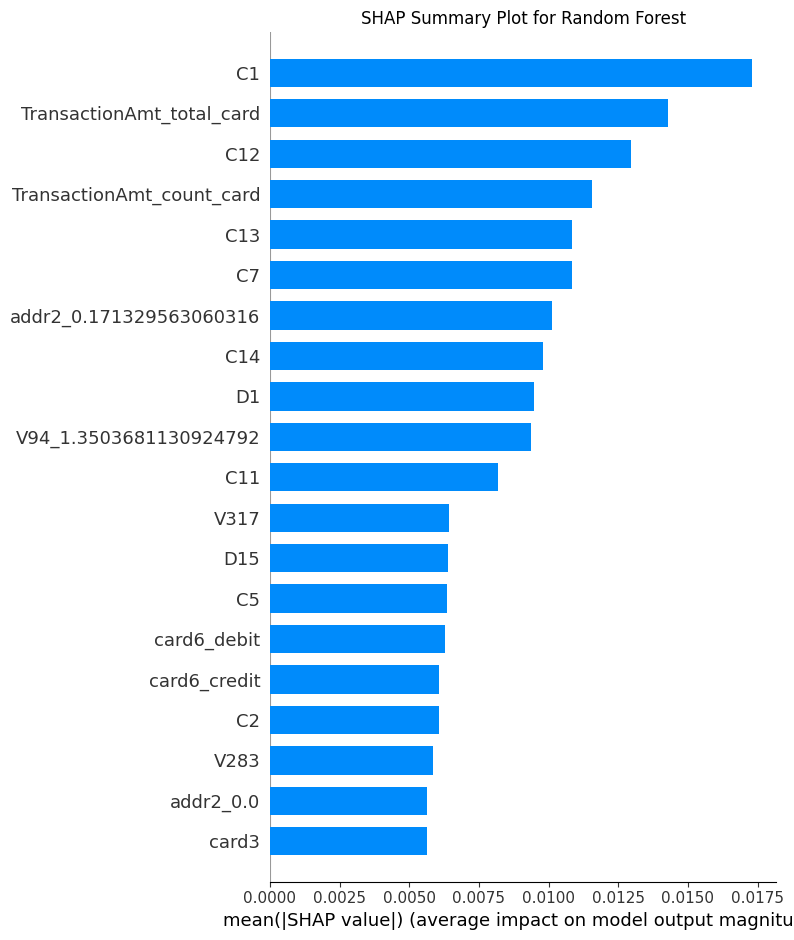

In [ ]:
# Check the shape of SHAP values for Random Forest
print("Shape of shap_values_rf:", shap_values_rf.values.shape)

# Handle binary classification case
if len(shap_values_rf.values.shape) > 2:
    shap_values_rf_class_1 = shap_values_rf[..., 1]
else:
    shap_values_rf_class_1 = shap_values_rf.values

# Extract SHAP values for class 1 (fraud) in Random Forest
shap_values_rf_class_1 = shap_values_rf[..., 1]

# SHAP Summary Plot for Random Forest (Class 1 - Fraud)
plt.title("SHAP Summary Plot for Random Forest")
shap.summary_plot(shap_values_rf_class_1, X_test_cleaned, plot_type="bar")
plt.show()

In [ ]:
# SHAP Values for XGBoost
#explainer_xgb = shap.Explainer(xgb_model, X_train_cleaned)
#shap_values_xgb = explainer_xgb(X_test_cleaned)

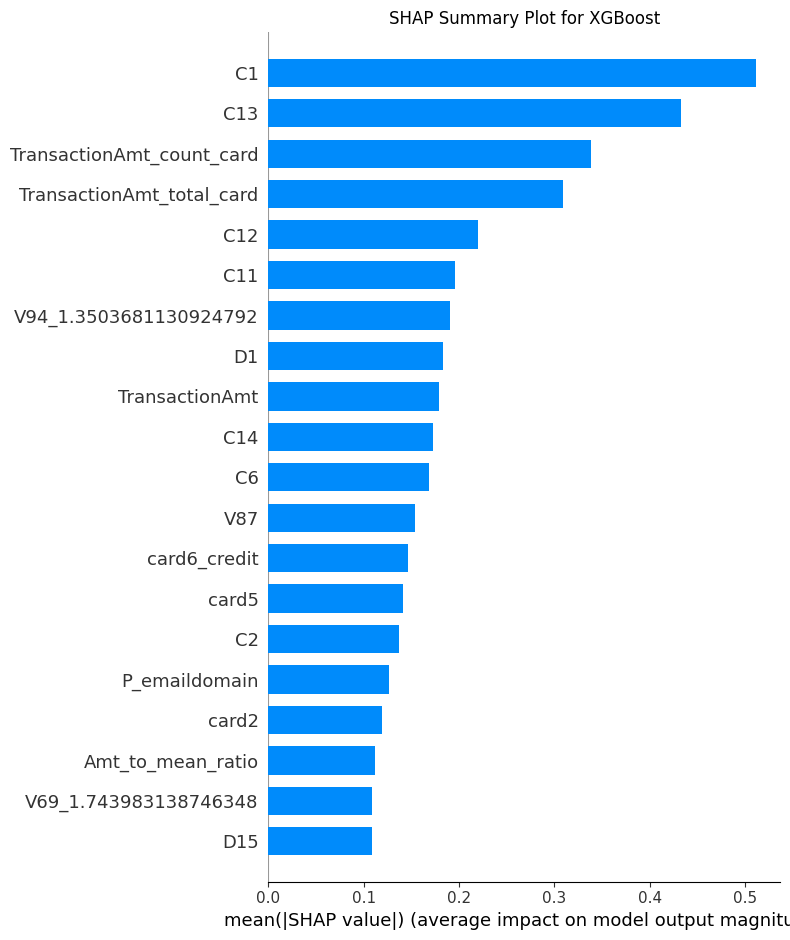

In [ ]:
# SHAP Summary Plot for XGBoost
plt.title("SHAP Summary Plot for XGBoost")
shap.summary_plot(shap_values_xgb, X_test_cleaned, plot_type="bar")
plt.show()


In [ ]:
# SHAP Values for the Hybrid Model (Logistic Regression Meta-Classifier)
# Stack predictions from Random Forest and XGBoost as input to the hybrid model
stacked_predictions = np.column_stack((y_pred_rf_proba, y_pred_xgb_proba))

In [ ]:
# Ensure the meta-classifier (Logistic Regression) is trained
if 'meta_classifier' in globals():
    print("Meta-classifier is available. Proceeding with SHAP for the hybrid model...")
else:
    raise ValueError("Meta-classifier is not defined. Please train the model first.")

Meta-classifier is available. Proceeding with SHAP for the hybrid model...


In [ ]:
# Train SHAP explainer for the meta-classifier (logistic regression) hybrid model
explainer_hybrid = shap.Explainer(meta_classifier, stacked_predictions)
shap_values_hybrid = explainer_hybrid(stacked_predictions)

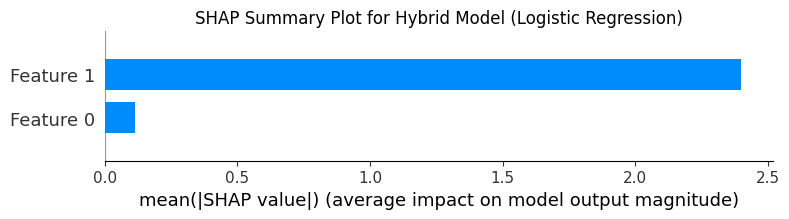

In [ ]:
# SHAP Summary Plot for the Hybrid Model (Logistic Regression)
plt.title("SHAP Summary Plot for Hybrid Model (Logistic Regression)")
shap.summary_plot(shap_values_hybrid, stacked_predictions, plot_type="bar")
plt.show()

Plotting SHAP Dependence Plot for 'TransactionAmt' in Random Forest, XGBoost, and Hybrid Model...


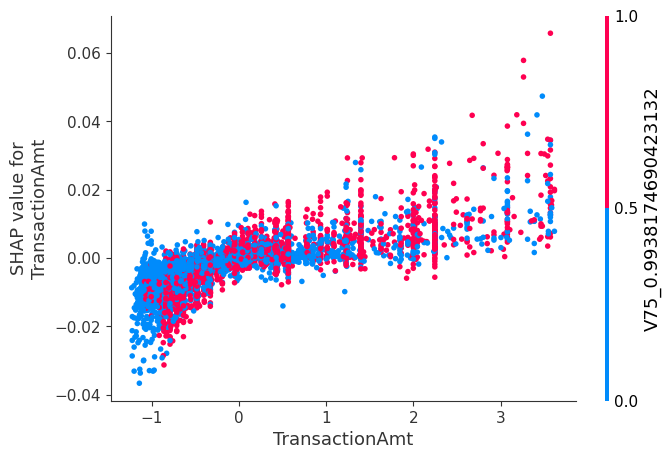

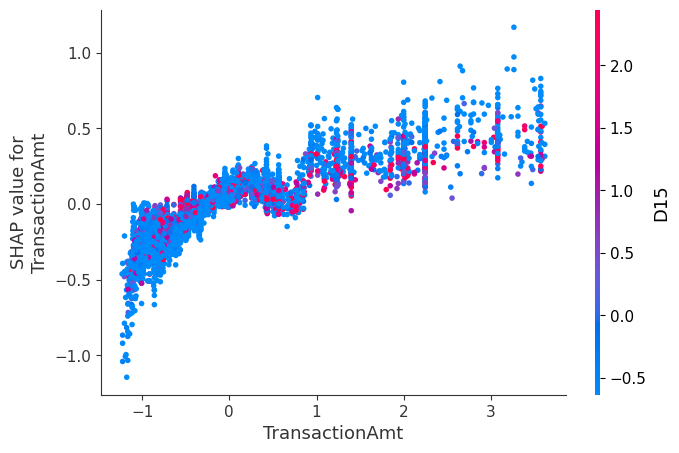

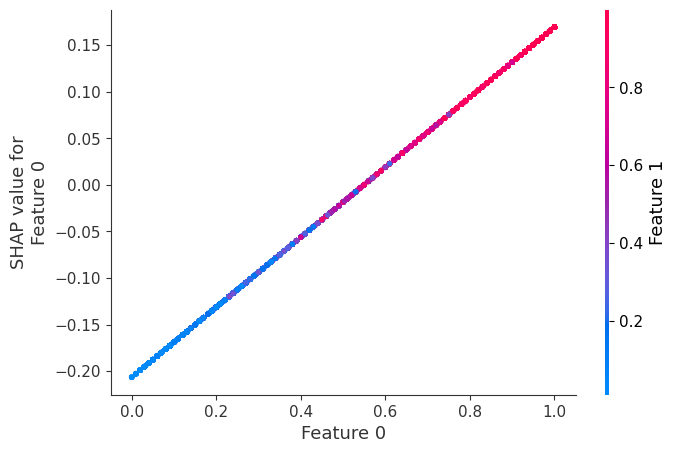

In [ ]:
# SHAP Dependence Plot for Random Forest, XGBoost, and Hybrid Model
if 'TransactionAmt' in X_test_cleaned.columns:
    print("Plotting SHAP Dependence Plot for 'TransactionAmt' in Random Forest, XGBoost, and Hybrid Model...")

    # Ensure SHAP values are properly extracted for Random Forest (Class 1 - Fraud)
    if shap_values_rf.values.ndim == 3:
        # Multi-class case, extract class 1 (fraud)
        shap_values_rf_class_1 = shap_values_rf.values[:, :, 1]  # Class 1 SHAP values
    else:
        shap_values_rf_class_1 = shap_values_rf.values  # Already binary

    # Ensure SHAP values are properly aligned with X_test_cleaned
    if shap_values_rf_class_1.shape[0] != X_test_cleaned.shape[0]:
        raise ValueError("Mismatch between SHAP values and X_test_cleaned rows for Random Forest.")

    # SHAP Dependence Plot for Random Forest
    shap.dependence_plot("TransactionAmt", shap_values_rf_class_1, X_test_cleaned)
    plt.show()

    # Ensure SHAP values are properly extracted for XGBoost (binary classification)
    shap_values_xgb_class_1 = shap_values_xgb.values  # Directly using values since it's binary classification

    if shap_values_xgb_class_1.shape[0] != X_test_cleaned.shape[0]:
        raise ValueError("Mismatch between SHAP values and X_test_cleaned rows for XGBoost.")

    # SHAP Dependence Plot for XGBoost
    shap.dependence_plot("TransactionAmt", shap_values_xgb_class_1, X_test_cleaned)
    plt.show()

    # Ensure SHAP values are properly extracted for Hybrid Model (Logistic Regression)
    shap_values_hybrid_class_1 = shap_values_hybrid.values  # Use for hybrid model

    if shap_values_hybrid_class_1.shape[0] != stacked_predictions.shape[0]:
        raise ValueError("Mismatch between SHAP values and stacked_predictions rows for Hybrid Model.")

    # SHAP Dependence Plot for Hybrid Model (Logistic Regression)
    shap.dependence_plot(0, shap_values_hybrid_class_1, stacked_predictions)
    plt.show()

else:
    print("Error: 'TransactionAmt' not found in X_test_cleaned.")